# BLM example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Add PyTwoWay to system path (SET THESE TO WHERE YOU HAVE THE PACKAGE REPOSITORIES CLONED)
import sys
sys.path.append('../../..')

In [3]:
# Import the PyTwoWay package 
# (Make sure you have installed it using pip install pytwoway)
import numpy as np
import bipartitepandas as bpd
import pytwoway as tw
from matplotlib import pyplot as plt

## First, check out parameter options

In [4]:
print('----- BLM -----')
tw.blm_params().describe_all()
print('----- Clustering -----')
bpd.cluster_params().describe_all()
print('----- Cleaning -----')
bpd.clean_params().describe_all()
print('----- Simulation -----')
bpd.sim_params().describe_all()

----- BLM -----
KEY: 'nl'
CURRENT VALUE: 6
VALID VALUES: one of type <class 'int'>
CONSTRAINTS: '>= 1'
DESCRIPTION: 
            (default=6) Number of worker types.
        
KEY: 'nk'
CURRENT VALUE: 10
VALID VALUES: one of type <class 'int'>
CONSTRAINTS: '>= 1'
DESCRIPTION: 
            (default=10) Number of firm types.
        
KEY: 'categorical_time_varying_worker_interaction_controls_dict'
CURRENT VALUE: None
VALID VALUES: None or dictionary of type <class 'bipartitepandas.util.ParamsDict'>
DESCRIPTION: 
            (default=None) Dictionary linking column names to instances of tw.sim_categorical_time_varying_worker_interaction_params(). Each instance specifies a new control variable where the effect interacts with worker types and can vary between the first and second periods. Run tw.sim_categorical_time_varying_worker_interaction_params().describe_all() for descriptions of all valid parameters. None is equivalent to {}.
        
KEY: 'categorical_time_nonvarying_worker_interactio

## Second, set parameter choices

In [6]:
nl = 2 # Number of worker types
nk = 3 # Number of firm types
blm_params = tw.blm_params({'nl': nl, 'nk': nk, 'fixb': False, 'stationary': False, 'n_iters_movers': 100, 'threshold_movers': 1e-7, 'd_prior_j': 1.0001, 'verbose': 0, 'categorical_time_varying_controls_dict': {'l': tw.sim_categorical_time_varying_params({'n': nl})}, 'verbose': 2})
cluster_params = bpd.cluster_params({'measures': bpd.measures.CDFs(), 'grouping': bpd.grouping.KMeans(n_clusters=nk), 'is_sorted': True, 'copy': False})
clean_params = bpd.clean_params({'drop_returns': 'returners', 'copy': False})
sim_params = bpd.sim_params({'nl': nl, 'nk': nk, 'c_sort': 0, 'c_netw': 0, 'c_sig': 1})

## Simulate data

Simulate a bipartite network using BipartitePandas. We use this here to demonstrate how to fit the estimator using real data.

In [10]:
sim_data = bpd.BipartiteDataFrame(bpd.SimBipartite(sim_params).simulate()[['i', 'j', 'y', 't', 'l', 'alpha', 'k', 'psi']]).clean(clean_params).collapse(is_sorted=True, copy=False).to_eventstudy(is_sorted=True, copy=False) #.cluster(cluster_params).collapse(is_sorted=True, copy=False).to_eventstudy(is_sorted=True, copy=False)
sim_data[['g1', 'g2']] = sim_data[['k1', 'k2']]
print('Movers data')
display(sim_data[sim_data['m'] > 0])
print('Stayers data')
display(sim_data[sim_data['m'] == 0])

checking required columns and datatypes
sorting rows
dropping NaN observations
generating 'm' column
keeping highest paying job for i-t (worker-year) duplicates (how='max')
dropping workers who leave a firm then return to it (how='returners')
making 'i' ids contiguous
making 'j' ids contiguous
computing largest connected set (how=None)
sorting columns
resetting index
Movers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,w1,...,alpha1,alpha2,k1,k2,l1,l2,psi1,psi2,g1,g2
0,0,120,103,-1.377773,-0.892341,0,1,2,3,2,...,-0.430727,-0.430727,1.0,1.0,0.0,0.0,0.00000,0.00000,1.0,1.0
1,0,103,167,-0.892341,-0.555591,2,3,4,4,2,...,-0.430727,-0.430727,1.0,2.0,0.0,0.0,0.00000,0.67449,1.0,2.0
2,1,112,80,-0.552927,-1.253256,0,0,1,1,1,...,-0.430727,-0.430727,1.0,1.0,0.0,0.0,0.00000,0.00000,1.0,1.0
3,1,80,161,-1.253256,0.390754,1,1,2,3,1,...,-0.430727,-0.430727,1.0,2.0,0.0,0.0,0.00000,0.67449,1.0,2.0
4,1,161,163,0.390754,1.217701,2,3,4,4,2,...,-0.430727,-0.430727,2.0,2.0,0.0,0.0,0.67449,0.67449,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20400,9924,155,42,1.005642,0.192548,1,3,4,4,3,...,0.430727,0.430727,2.0,0.0,1.0,1.0,0.67449,-0.67449,2.0,0.0
20401,9925,26,139,-1.015314,-0.333577,0,1,2,2,2,...,-0.430727,-0.430727,0.0,1.0,0.0,0.0,-0.67449,0.00000,0.0,1.0
20402,9925,139,166,-0.333577,1.382905,2,2,3,4,1,...,-0.430727,-0.430727,1.0,2.0,0.0,0.0,0.00000,0.67449,1.0,2.0
20403,9926,61,14,0.582800,-0.171503,0,0,1,1,1,...,0.430727,0.430727,1.0,0.0,1.0,1.0,0.00000,-0.67449,1.0,0.0


Stayers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,w1,...,alpha1,alpha2,k1,k2,l1,l2,psi1,psi2,g1,g2
47,23,122,122,-0.361278,-0.361278,0,4,0,4,5,...,-0.430727,-0.430727,1.0,1.0,0.0,0.0,0.00000,0.00000,1.0,1.0
57,31,114,114,0.298999,0.298999,0,4,0,4,5,...,0.430727,0.430727,1.0,1.0,1.0,1.0,0.00000,0.00000,1.0,1.0
58,32,166,166,0.031522,0.031522,0,4,0,4,5,...,0.430727,0.430727,2.0,2.0,1.0,1.0,0.67449,0.67449,2.0,2.0
77,44,97,97,-0.273272,-0.273272,0,4,0,4,5,...,-0.430727,-0.430727,1.0,1.0,0.0,0.0,0.00000,0.00000,1.0,1.0
170,88,76,76,0.123746,0.123746,0,4,0,4,5,...,0.430727,0.430727,1.0,1.0,1.0,1.0,0.00000,0.00000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20132,9793,2,2,-0.506454,-0.506454,0,4,0,4,5,...,0.430727,0.430727,0.0,0.0,1.0,1.0,-0.67449,-0.67449,0.0,0.0
20158,9809,111,111,-0.764991,-0.764991,0,4,0,4,5,...,-0.430727,-0.430727,1.0,1.0,0.0,0.0,0.00000,0.00000,1.0,1.0
20247,9853,166,166,0.213791,0.213791,0,4,0,4,5,...,-0.430727,-0.430727,2.0,2.0,0.0,0.0,0.67449,0.67449,2.0,2.0
20257,9858,133,133,0.013215,0.013215,0,4,0,4,5,...,0.430727,0.430727,1.0,1.0,1.0,1.0,0.00000,0.00000,1.0,1.0


## Initialize and run BLMEstimator

In [14]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=sim_data[sim_data['m'] > 0], sdata=sim_data[sim_data['m'] == 0], n_init=40, n_best=5, ncore=1)

  0%|                                                    | 0/40 [00:00<?, ?it/s]

Running fixm movers
loop 0, liks -19.185394214016572
loop 1, liks -5.607301923048361
loop 2, liks -5.611820244664251
loop 3, liks -5.609655931858524
loop 4, liks -5.6075157327641
loop 5, liks -5.605395511196151
loop 6, liks -5.60329861898121
loop 7, liks -5.601231199727181
loop 8, liks -5.599199199753706
loop 9, liks -5.597208111411049
loop 10, liks -5.59526288111079
loop 11, liks -5.59336784497988
loop 12, liks -5.591526686692311
loop 13, liks -5.589742416897872
loop 14, liks -5.588017372842712
loop 15, liks -5.586353235923153
loop 16, liks -5.584751064314885
loop 17, liks -5.5832113374911945
loop 18, liks -5.5817340093661425
loop 19, liks -5.580318566931646
loop 20, liks -5.578964091550881
loop 21, liks -5.577669320469332
loop 22, liks -5.576432706558834
loop 23, liks -5.575252474775267
loop 24, liks -5.574126674253976
loop 25, liks -5.573053225364388
loop 26, liks -5.5720299613842075
loop 27, liks -5.571054664727539
loop 28, liks -5.570125097871339
loop 29, liks -5.5692390292761536


  2%|█                                           | 1/40 [00:02<01:34,  2.41s/it]

loop 3, liks -2.7251435951487037
loop 4, liks -2.7251408328383673
loop 5, liks -2.7251397619413096
loop 6, liks -2.7251394273148604
loop 7, liks -2.7251394262912028
Running fixm movers
loop 0, liks -10.354620847617163
loop 1, liks -4.5197986279526745
loop 2, liks -4.5888082889337865
loop 3, liks -4.592303979842318
loop 4, liks -4.590592312188043
loop 5, liks -4.588464624711519
loop 6, liks -4.5863556949748086
loop 7, liks -4.584314644064373
loop 8, liks -4.582346253562585
loop 9, liks -4.5804497609509935
loop 10, liks -4.578623771330177
loop 11, liks -4.576866876843067
loop 12, liks -4.575177714397815
loop 13, liks -4.573554949339202
loop 14, liks -4.571997250812563
loop 15, liks -4.570503268711959
loop 16, liks -4.569071614323404
loop 17, liks -4.567700845381093
loop 18, liks -4.5663894557634706
loop 19, liks -4.565135869742953
loop 20, liks -4.563938440473397
loop 21, liks -4.562795452235706
loop 22, liks -4.561705125858123
loop 23, liks -4.560665626675915
loop 24, liks -4.5596750743

  5%|██▏                                         | 2/40 [00:04<01:33,  2.46s/it]

loop 5, liks -2.725160662833627
loop 6, liks -2.7251605091201077
loop 7, liks -2.7251605457351675
Running fixm movers
loop 0, liks -19.753077023343742
loop 1, liks -5.421920765063932
loop 2, liks -5.4452847036737895
loop 3, liks -5.445456463495231
loop 4, liks -5.444181178096454
loop 5, liks -5.442794037606762
loop 6, liks -5.441396858584958
loop 7, liks -5.440000195379182
loop 8, liks -5.4386070364658385
loop 9, liks -5.437219837438802
loop 10, liks -5.435841105737922
loop 11, liks -5.4344734301777935
loop 12, liks -5.43311945841579
loop 13, liks -5.4317818661508355
loop 14, liks -5.430463322737621
loop 15, liks -5.4291664547112255
loop 16, liks -5.427893808549025
loop 17, liks -5.426647814020203
loop 18, liks -5.425430749441043
loop 19, liks -5.424244710049604
loop 20, liks -5.423091580543509
loop 21, liks -5.421973012603936
loop 22, liks -5.420890407974398
loop 23, liks -5.419844907394307
loop 24, liks -5.418837385422862
loop 25, liks -5.417868450945022
loop 26, liks -5.416938452941

  8%|███▎                                        | 3/40 [00:07<01:31,  2.49s/it]

loop 3, liks -2.7248977262378085
loop 4, liks -2.72489780677816
Running fixm movers
loop 0, liks -16.357332151646286
loop 1, liks -5.211182021367732
loop 2, liks -5.215848549702877
loop 3, liks -5.214232073260291
loop 4, liks -5.212376072150868
loop 5, liks -5.210574000673419
loop 6, liks -5.2088376760803206
loop 7, liks -5.207167409902404
loop 8, liks -5.2055628036076165
loop 9, liks -5.204023194368027
loop 10, liks -5.20254768747143
loop 11, liks -5.201135174914701
loop 12, liks -5.199784355711407
loop 13, liks -5.198493757893044
loop 14, liks -5.197261761552187
loop 15, liks -5.19608662228422
loop 16, liks -5.194966494444392
loop 17, liks -5.193899453715998
loop 18, liks -5.1928835185752185
loop 19, liks -5.1919166703301665
loop 20, liks -5.190996871501845
loop 21, liks -5.190122082397963
loop 22, liks -5.18929027580424
loop 23, liks -5.188499449781086
loop 24, liks -5.187747638604685
loop 25, liks -5.187032921931901
loop 26, liks -5.186353432298026
loop 27, liks -5.185707361076706


 10%|████▍                                       | 4/40 [00:10<01:32,  2.56s/it]

loop 4, liks -2.7252017522391827
loop 5, liks -2.7251986638606236
loop 6, liks -2.7251970165483654
loop 7, liks -2.72519617083166
loop 8, liks -2.725195765876538
loop 9, liks -2.7251956017413703
loop 10, liks -2.725195568651044
Running fixm movers
loop 0, liks -16.91940347641509
loop 1, liks -5.542624717623889
loop 2, liks -5.546914930891865
loop 3, liks -5.546191581847869
loop 4, liks -5.545460479606016
loop 5, liks -5.544749388192766
loop 6, liks -5.544058137980549
loop 7, liks -5.543386362994677
loop 8, liks -5.542733699308288
loop 9, liks -5.54209978571846
loop 10, liks -5.54148426303053
loop 11, liks -5.540886773479362
loop 12, liks -5.540306960286606
loop 13, liks -5.539744467340469
loop 14, liks -5.5391989389850345
loop 15, liks -5.538670019906475
loop 16, liks -5.538157355104539
loop 17, liks -5.537660589937947
loop 18, liks -5.537179370233132
loop 19, liks -5.536713342446618
loop 20, liks -5.536262153871787
loop 21, liks -5.535825452881617
loop 22, liks -5.535402889199659
loop

 12%|█████▌                                      | 5/40 [00:14<01:57,  3.37s/it]

loop 98, liks -2.7248882752522
loop 99, liks -2.7248881718145515
Running fixm movers
loop 0, liks -15.100789015376758
loop 1, liks -5.211117726919321
loop 2, liks -5.255682575730014
loop 3, liks -5.257942533309935
loop 4, liks -5.257405614398854
loop 5, liks -5.2567485594670655
loop 6, liks -5.256129955178841
loop 7, liks -5.255560391060701
loop 8, liks -5.25503796122142
loop 9, liks -5.254559677391061
loop 10, liks -5.2541225371168165
loop 11, liks -5.253723642540054
loop 12, liks -5.253360226307061
loop 13, liks -5.253029664065739
loop 14, liks -5.252729481575862
loop 15, liks -5.252457357877789
loop 16, liks -5.25221112530952
loop 17, liks -5.251988767035382
loop 18, liks -5.2517884126652365
loop 19, liks -5.2516083324617355
loop 20, liks -5.251446930555213
loop 21, liks -5.251302737513252
loop 22, liks -5.251174402546955
loop 23, liks -5.251060685578545
loop 24, liks -5.250960449345365
loop 25, liks -5.2508726516736255
loop 26, liks -5.2507963380201685
loop 27, liks -5.250730634351

 15%|██████▌                                     | 6/40 [00:17<01:46,  3.12s/it]

loop 2, liks -2.7251800637973806
loop 3, liks -2.7251784746494048
loop 4, liks -2.725177851555838
loop 5, liks -2.725177672214357
loop 6, liks -2.7251776949553284
Running fixm movers
loop 0, liks -13.548977640402908
loop 1, liks -5.1253460040328305
loop 2, liks -5.128961515271038
loop 3, liks -5.127067432239825
loop 4, liks -5.125076102010528
loop 5, liks -5.123170576126559
loop 6, liks -5.121359681604988
loop 7, liks -5.119642600696044
loop 8, liks -5.11801766840959
loop 9, liks -5.1164828934434725
loop 10, liks -5.115036024667244
loop 11, liks -5.113674584018879
loop 12, liks -5.112395892239856
loop 13, liks -5.111197091793873
loop 14, liks -5.1100751693069855
loop 15, liks -5.109026978948646
loop 16, liks -5.108049267396336
loop 17, liks -5.1071387003997435
loop 18, liks -5.106291890509653
loop 19, liks -5.105505425262305
loop 20, liks -5.104775894992009
loop 21, liks -5.104099919450682
loop 22, liks -5.103474172508336
loop 23, liks -5.102895404357155
loop 24, liks -5.10236046081545

 18%|███████▋                                    | 7/40 [00:21<01:56,  3.54s/it]

loop 7, liks -2.7252034647172994
Running fixm movers
loop 0, liks -13.501777404910841
loop 1, liks -4.871286209087811
loop 2, liks -4.88736939817878
loop 3, liks -4.885486640198071
loop 4, liks -4.882796715626271
loop 5, liks -4.880180626645381
loop 6, liks -4.877708389345783
loop 7, liks -4.875381384711099
loop 8, liks -4.873193992486439
loop 9, liks -4.8711396943887895
loop 10, liks -4.869211789042142
loop 11, liks -4.867403553682506
loop 12, liks -4.865708334216535
loop 13, liks -4.8641196130932345
loop 14, liks -4.862631061520321
loop 15, liks -4.86123657837492
loop 16, liks -4.859930317741958
loop 17, liks -4.85870670689663
loop 18, liks -4.8575604564110835
loop 19, liks -4.8564865638986
loop 20, liks -4.855480312727662
loop 21, liks -4.8545372668552
loop 22, liks -4.85365326275312
loop 23, liks -4.85282439923982
loop 24, liks -4.852047025882465
loop 25, liks -4.851317730507235
loop 26, liks -4.8506333262438766
loop 27, liks -4.849990838436619
loop 28, liks -4.849387491674355
loop

 20%|████████▊                                   | 8/40 [00:26<01:59,  3.73s/it]

loop 85, liks -2.7251322973962626
loop 86, liks -2.7251321964477264
loop 87, liks -2.7251320962007095
loop 88, liks -2.725131996651483
Running unconstrained movers
loop 0, liks -2.725131996651483
loop 1, liks -2.7251318927750647
loop 2, liks -2.7251317977229657
Running fixm movers
loop 0, liks -13.107380627894004
loop 1, liks -4.968655527329323
loop 2, liks -4.9959314667362
loop 3, liks -4.995371172546065
loop 4, liks -4.993535726587915
loop 5, liks -4.991692540104791
loop 6, liks -4.989909672517725
loop 7, liks -4.988192235034676
loop 8, liks -4.986540278005142
loop 9, liks -4.984953162776001
loop 10, liks -4.9834299781166616
loop 11, liks -4.9819695990978285
loop 12, liks -4.980570712066435
loop 13, liks -4.979231837622696
loop 14, liks -4.977951354317431
loop 15, liks -4.976727522715749
loop 16, liks -4.9755585091981755
loop 17, liks -4.974442408926186
loop 18, liks -4.973377267505756
loop 19, liks -4.9723611009984845
loop 20, liks -4.971391914043018
loop 21, liks -4.970467715952107

 22%|█████████▉                                  | 9/40 [00:28<01:43,  3.33s/it]

Running fixm movers
loop 0, liks -15.161732750738084
loop 1, liks -5.314170718424432
loop 2, liks -5.30986572195749
loop 3, liks -5.307821666546386
loop 4, liks -5.305807541488382
loop 5, liks -5.303911181482778
loop 6, liks -5.302131901860414
loop 7, liks -5.30046210029681
loop 8, liks -5.298893961715278
loop 9, liks -5.297419985435526
loop 10, liks -5.296033040755264
loop 11, liks -5.294726382253399
loop 12, liks -5.293493656188384
loop 13, liks -5.292328901060658
loop 14, liks -5.29122654342626
loop 15, liks -5.290181389854711
loop 16, liks -5.289188615836778
loop 17, liks -5.2882437523609935
loop 18, liks -5.287342670787652
loop 19, liks -5.286481566560719
loop 20, liks -5.2856569422130875
loop 21, liks -5.284865590042258
loop 22, liks -5.284104574762282
loop 23, liks -5.283371216374498
loop 24, liks -5.282663073444346
loop 25, liks -5.2819779269242435
loop 26, liks -5.281313764622377
loop 27, liks -5.280668766384053
loop 28, liks -5.280041290025046
loop 29, liks -5.279429858034412

 25%|██████████▊                                | 10/40 [00:33<01:51,  3.71s/it]

loop 95, liks -2.7252310650713567
loop 96, liks -2.725230859247313
loop 97, liks -2.7252306527950374
loop 98, liks -2.725230445715811
loop 99, liks -2.725230238010954
Running fixm movers
loop 0, liks -30.123591592108404
loop 1, liks -6.210324090096278
loop 2, liks -6.21985936234974
loop 3, liks -6.219312605837731
loop 4, liks -6.218664247671239
loop 5, liks -6.218059274716934
loop 6, liks -6.217495664870724
loop 7, liks -6.216968665859944
loop 8, liks -6.216474064268541
loop 9, liks -6.216008200846176
loop 10, liks -6.215567903671832
loop 11, liks -6.215150426309053
loop 12, liks -6.214753392879864
loop 13, liks -6.214374749535282
loop 14, liks -6.214012721727516
loop 15, liks -6.2136657767035155
loop 16, liks -6.213332590668754
loop 17, liks -6.213012020107012
loop 18, liks -6.212703076782674
loop 19, liks -6.212404905994479
loop 20, liks -6.212116767690987
loop 21, liks -6.211838020098357
loop 22, liks -6.211568105548543
loop 23, liks -6.211306538230904
loop 24, liks -6.2110528936221

 28%|███████████▊                               | 11/40 [00:35<01:35,  3.29s/it]

loop 2, liks -2.725052459074253
loop 3, liks -2.7250521525349787
loop 4, liks -2.725052045798779
loop 5, liks -2.7250519516882
Running fixm movers
loop 0, liks -15.977631703970902
loop 1, liks -5.214994962094459
loop 2, liks -5.207386249831086
loop 3, liks -5.202172169234288
loop 4, liks -5.197261437526237
loop 5, liks -5.1925790152226865
loop 6, liks -5.1881309263544075
loop 7, liks -5.183923129669254
loop 8, liks -5.179958823688199
loop 9, liks -5.176238448314855
loop 10, liks -5.172759857278487
loop 11, liks -5.169518570208617
loop 12, liks -5.16650807872374
loop 13, liks -5.163720183224768
loop 14, liks -5.161145339423758
loop 15, liks -5.158772997081831
loop 16, liks -5.156591917435998
loop 17, liks -5.1545904598638765
loop 18, liks -5.1527568320965935
loop 19, liks -5.151079301505078
loop 20, liks -5.1495463675417925
loop 21, liks -5.148146897301294
loop 22, liks -5.146870227421873
loop 23, liks -5.145706236277886
loop 24, liks -5.144645390716397
loop 25, liks -5.1436787715804115

 30%|████████████▉                              | 12/40 [00:37<01:22,  2.96s/it]

loop 98, liks -5.132982217534973
loop 99, liks -5.132977013846726
Running constrained movers
loop 0, liks -5.132972092661381
loop 1, liks -2.7252783113693324
loop 2, liks -2.7252767330248235
loop 3, liks -2.7252766330315707
Running unconstrained movers
loop 0, liks -2.7252766330315707
loop 1, liks -2.7252765539313812
Running fixm movers
loop 0, liks -16.893991739694876
loop 1, liks -5.543126317999253
loop 2, liks -5.562057633596819
loop 3, liks -5.561520204334684
loop 4, liks -5.5609084795784005
loop 5, liks -5.56031032798854
loop 6, liks -5.559725607184263
loop 7, liks -5.559153599760299
loop 8, liks -5.558593596541221
loop 9, liks -5.558044908028618
loop 10, liks -5.557506870246243
loop 11, liks -5.556978849609364
loop 12, liks -5.556460246906703
loop 13, liks -5.555950500449295
loop 14, liks -5.555449088445607
loop 15, liks -5.554955530664869
loop 16, liks -5.554469389451786
loop 17, liks -5.55399027015556
loop 18, liks -5.553517821034515
loop 19, liks -5.553051732695839
loop 20, li

 32%|█████████████▉                             | 13/40 [00:39<01:14,  2.76s/it]

loop 2, liks -2.7249174902205247
loop 3, liks -2.7249122706304165
loop 4, liks -2.724911055963857
loop 5, liks -2.7249109779141487
Running fixm movers
loop 0, liks -14.218516722169545
loop 1, liks -4.826206675695177
loop 2, liks -4.8391276206816105
loop 3, liks -4.838249012628854
loop 4, liks -4.837280948300787
loop 5, liks -4.836382535236337
loop 6, liks -4.835548230205862
loop 7, liks -4.834769563975809
loop 8, liks -4.834038928780847
loop 9, liks -4.8333496194863965
loop 10, liks -4.8326957586056425
loop 11, liks -4.832072217626496
loop 12, liks -4.83147454090133
loop 13, liks -4.830898873970922
loop 14, liks -4.830341897334786
loop 15, liks -4.829800766130078
loop 16, liks -4.829273055793943
loop 17, liks -4.8287567135215355
loop 18, liks -4.828250015162908
loop 19, liks -4.827751527102553
loop 20, liks -4.827260072616441
loop 21, liks -4.826774702188342
loop 22, liks -4.826294667278505
loop 23, liks -4.8258193970662955
loop 24, liks -4.8253484777266715
loop 25, liks -4.82488163384

 35%|███████████████                            | 14/40 [00:42<01:07,  2.59s/it]

loop 2, liks -2.725131796856268
loop 3, liks -2.725132193921279
loop 4, liks -2.7251324404900066
loop 5, liks -2.725132571002917
loop 6, liks -2.7251326415392634
Running unconstrained movers
loop 0, liks -2.7251326415392634
loop 1, liks -2.7251224816784374
loop 2, liks -2.7251224492038713
Running fixm movers
loop 0, liks -14.65815180115637
loop 1, liks -4.961483402610184
loop 2, liks -4.975835657421596
loop 3, liks -4.975218327358542
loop 4, liks -4.9745020406650635
loop 5, liks -4.973829055388932
loop 6, liks -4.973196681190782
loop 7, liks -4.972600641346867
loop 8, liks -4.97203717744819
loop 9, liks -4.9715030519316805
loop 10, liks -4.970995507203717
loop 11, liks -4.970512222180397
loop 12, liks -4.970051267545223
loop 13, liks -4.969611060174911
loop 14, liks -4.96919031731085
loop 15, liks -4.96878801120304
loop 16, liks -4.968403325072777
loop 17, liks -4.968035611307063
loop 18, liks -4.967684352796413
loop 19, liks -4.967349128250913
loop 20, liks -4.967029582179899
loop 21,

 38%|████████████████▏                          | 15/40 [00:44<01:01,  2.47s/it]

loop 99, liks -4.964261167685397
Running constrained movers
loop 0, liks -4.964262758019187
loop 1, liks -2.7252598717867604
loop 2, liks -2.7252517909249443
loop 3, liks -2.725251970529653
loop 4, liks -2.7252520551205546
Running unconstrained movers
loop 0, liks -2.7252520551205546
loop 1, liks -2.7252210477311283
loop 2, liks -2.7252210032496085
Running fixm movers
loop 0, liks -15.545123286032847
loop 1, liks -5.439077369895501
loop 2, liks -5.461133133603104
loop 3, liks -5.457974274219435
loop 4, liks -5.454522151546605
loop 5, liks -5.451184348290409
loop 6, liks -5.447970667204106
loop 7, liks -5.444883601091638
loop 8, liks -5.441924707341519
loop 9, liks -5.439094711408304
loop 10, liks -5.43639354082025
loop 11, liks -5.433820375270401
loop 12, liks -5.431373707841196
loop 13, liks -5.429051413988374
loop 14, liks -5.426850825344058
loop 15, liks -5.42476880567912
loop 16, liks -5.422801826704333
loop 17, liks -5.420946041772875
loop 18, liks -5.419197355944621
loop 19, liks

 40%|█████████████████▏                         | 16/40 [00:46<00:57,  2.40s/it]

loop 2, liks -2.7252221463633903
loop 3, liks -2.7252221296142367
Running unconstrained movers
loop 0, liks -2.7252221296142367
loop 1, liks -2.7252108432524174
loop 2, liks -2.725210750342188
Running fixm movers
loop 0, liks -21.01170142034626
loop 1, liks -5.655696485888702
loop 2, liks -5.680734869338729
loop 3, liks -5.674856272527533
loop 4, liks -5.668822096001149
loop 5, liks -5.66282638543725
loop 6, liks -5.6568748762966905
loop 7, liks -5.650976618149037
loop 8, liks -5.645141165137138
loop 9, liks -5.639378298181556
loop 10, liks -5.6336979114793335
loop 11, liks -5.628109854244956
loop 12, liks -5.622623729564034
loop 13, liks -5.6172486684484655
loop 14, liks -5.611993101028146
loop 15, liks -5.606864547254116
loop 16, liks -5.601869446903129
loop 17, liks -5.597013043537269
loop 18, liks -5.59229933026847
loop 19, liks -5.5877310578295365
loop 20, liks -5.583309798690862
loop 21, liks -5.579036055704459
loop 22, liks -5.574909400566575
loop 23, liks -5.570928626422203
loo

 42%|██████████████████▎                        | 17/40 [00:48<00:55,  2.40s/it]

loop 1, liks -2.725366807912196
loop 2, liks -2.7252766280254783
loop 3, liks -2.7252765299238577
Running unconstrained movers
loop 0, liks -2.7252765299238577
loop 1, liks -2.7252764086874963
loop 2, liks -2.7252763251148453
Running fixm movers
loop 0, liks -16.4822289930377
loop 1, liks -5.3882538308010925
loop 2, liks -5.431584755807162
loop 3, liks -5.434232711936491
loop 4, liks -5.43320639434454
loop 5, liks -5.431907338915327
loop 6, liks -5.430610759458652
loop 7, liks -5.429346804680741
loop 8, liks -5.428120397751534
loop 9, liks -5.426933384196964
loop 10, liks -5.425786895399736
loop 11, liks -5.424681629187477
loop 12, liks -5.4236179135526905
loop 13, liks -5.422595749649915
loop 14, liks -5.421614853423306
loop 15, liks -5.4206746967294475
loop 16, liks -5.419774547097164
loop 17, liks -5.418913505308954
loop 18, liks -5.418090540200035
loop 19, liks -5.41730452027681
loop 20, liks -5.416554241934218
loop 21, liks -5.4158384541986315
loop 22, liks -5.415155880039955
loop

 45%|███████████████████▎                       | 18/40 [00:51<00:54,  2.47s/it]

loop 4, liks -2.7252684657706663
loop 5, liks -2.7252680364945614
loop 6, liks -2.7252677658307483
loop 7, liks -2.7252675859989957
loop 8, liks -2.7252674573354514
loop 9, liks -2.7252673571592028
loop 10, liks -2.7252672726528138
Running fixm movers
loop 0, liks -17.113137241326584
loop 1, liks -5.445003686985433
loop 2, liks -5.4701785933218865
loop 3, liks -5.465808454804169
loop 4, liks -5.461304773555353
loop 5, liks -5.457274503948511
loop 6, liks -5.453672552946124
loop 7, liks -5.450442343429104
loop 8, liks -5.44753093885683
loop 9, liks -5.444889142888972
loop 10, liks -5.4424709845848565
loop 11, liks -5.440233124870459
loop 12, liks -5.438134222429843
loop 13, liks -5.436134274402389
loop 14, liks -5.434193947908541
loop 15, liks -5.432273922740058
loop 16, liks -5.430334272773024
loop 17, liks -5.428333924210364
loop 18, liks -5.426230243099356
loop 19, liks -5.42397882276406
loop 20, liks -5.42153356296052
loop 21, liks -5.41884715411745
loop 22, liks -5.415872096727772


 48%|████████████████████▍                      | 19/40 [00:54<00:53,  2.55s/it]

loop 0, liks -2.7252771032500624
loop 1, liks -2.7252771003662657
Running fixm movers
loop 0, liks -14.33535663213171
loop 1, liks -5.080231673937622
loop 2, liks -5.102739200970766
loop 3, liks -5.098921535293163
loop 4, liks -5.094207399475766
loop 5, liks -5.0897787290754115
loop 6, liks -5.085700335057548
loop 7, liks -5.08196347896426
loop 8, liks -5.078552875412786
loop 9, liks -5.075451475524938
loop 10, liks -5.072641116890478
loop 11, liks -5.070102885480151
loop 12, liks -5.067817449170803
loop 13, liks -5.065765375294545
loop 14, liks -5.063927425459034
loop 15, liks -5.062284819346574
loop 16, liks -5.060819460408501
loop 17, liks -5.059514118752442
loop 18, liks -5.058352569374031
loop 19, liks -5.057319686657316
loop 20, liks -5.056401498375234
loop 21, liks -5.055585204063197
loop 22, liks -5.054859163577724
loop 23, liks -5.054212861960433
loop 24, liks -5.053636856540439
loop 25, liks -5.053122711678374
loop 26, liks -5.052662925825799
loop 27, liks -5.052250854762413


 50%|█████████████████████▌                     | 20/40 [00:57<00:52,  2.65s/it]

loop 1, liks -2.725222245983558
loop 2, liks -2.7252216728658736
loop 3, liks -2.725221656381022
Running fixm movers
loop 0, liks -14.56114177518356
loop 1, liks -5.162848430612774
loop 2, liks -5.167229751165265
loop 3, liks -5.166194556512195
loop 4, liks -5.165252945225659
loop 5, liks -5.164474099053042
loop 6, liks -5.163827650929768
loop 7, liks -5.163287979968186
loop 8, liks -5.162834817532311
loop 9, liks -5.162452113951643
loop 10, liks -5.162127117306135
loop 11, liks -5.161849655229913
loop 12, liks -5.161611576748826
loop 13, liks -5.161406318841524
loop 14, liks -5.161228569774054
loop 15, liks -5.16107400732702
loop 16, liks -5.160939094906656
loop 17, liks -5.160820922380327
loop 18, liks -5.160717081485074
loop 19, liks -5.1606255679915485
loop 20, liks -5.160544704607247
loop 21, liks -5.160473079988971
loop 22, liks -5.160409500299024
loop 23, liks -5.160352950556047
loop 24, liks -5.16030256365796
loop 25, liks -5.160257595434527
loop 26, liks -5.160217404456285
loo

 52%|██████████████████████▌                    | 21/40 [00:59<00:48,  2.53s/it]

loop 87, liks -5.15985402503891
loop 88, liks -5.1598539339569935
Running constrained movers
loop 0, liks -5.1598539339569935
loop 1, liks -2.725279558472041
loop 2, liks -2.7252771112141
loop 3, liks -2.725277110906505
Running unconstrained movers
loop 0, liks -2.725277110906505
loop 1, liks -2.7252771106921747
Running fixm movers
loop 0, liks -20.851836864597313
loop 1, liks -5.63378988548915
loop 2, liks -5.636013818222199
loop 3, liks -5.63559255033619
loop 4, liks -5.635204708293601
loop 5, liks -5.63486386532308
loop 6, liks -5.634563801310703
loop 7, liks -5.634299016760439
loop 8, liks -5.6340647963324075
loop 9, liks -5.6338570949219955
loop 10, liks -5.633672439089745
loop 11, liks -5.633507843274662
loop 12, liks -5.633360738572193
loop 13, liks -5.6332289121710115
loop 14, liks -5.633110455830042
loop 15, liks -5.633003722023088
loop 16, liks -5.632907286587876
loop 17, liks -5.632819916894358
loop 18, liks -5.632740544698103
loop 19, liks -5.632668242972541
loop 20, liks -

 55%|███████████████████████▋                   | 22/40 [01:02<00:46,  2.58s/it]

loop 97, liks -5.631618497916998
loop 98, liks -5.631617165569268
loop 99, liks -5.631615887151069
Running constrained movers
loop 0, liks -5.631614660470796
loop 1, liks -2.7252833421692166
loop 2, liks -2.7252770031223745
loop 3, liks -2.7252769862534425
Running unconstrained movers
loop 0, liks -2.7252769862534425
loop 1, liks -2.7252769778637163
Running fixm movers
loop 0, liks -20.985332132146418
loop 1, liks -5.556826001224006
loop 2, liks -5.5910482439063065
loop 3, liks -5.589111941994195
loop 4, liks -5.586742995582249
loop 5, liks -5.584423858407423
loop 6, liks -5.582153502783732
loop 7, liks -5.579923885787714
loop 8, liks -5.577727916869361
loop 9, liks -5.575559656150473
loop 10, liks -5.573414336811787
loop 11, liks -5.571288369301229
loop 12, liks -5.56917933032605
loop 13, liks -5.567085935501072
loop 14, liks -5.565007994390333
loop 15, liks -5.56294634691949
loop 16, liks -5.560902780653536
loop 17, liks -5.558879929196875
loop 18, liks -5.55688115292553
loop 19, lik

 57%|████████████████████████▋                  | 23/40 [01:04<00:43,  2.57s/it]

loop 99, liks -5.518230900882848
Running constrained movers
loop 0, liks -5.518226871126395
loop 1, liks -2.7251669750725913
loop 2, liks -2.725153245199036
loop 3, liks -2.7251532460632033
Running unconstrained movers
loop 0, liks -2.7251532460632033
loop 1, liks -2.725081798543881
loop 2, liks -2.7250817453658907
Running fixm movers
loop 0, liks -13.029157442053076
loop 1, liks -4.8457475022154215
loop 2, liks -4.870796443425177
loop 3, liks -4.8680364639448515
loop 4, liks -4.86435977915221
loop 5, liks -4.860922360497664
loop 6, liks -4.857785299604687
loop 7, liks -4.854937734631389
loop 8, liks -4.852362711581316
loop 9, liks -4.850042418744232
loop 10, liks -4.847958798239191
loop 11, liks -4.846093812204898
loop 12, liks -4.844429682819883
loop 13, liks -4.842949113073185
loop 14, liks -4.841635476481738
loop 15, liks -4.8404729684583065
loop 16, liks -4.839446717143778
loop 17, liks -4.838542855284661
loop 18, liks -4.837748557140898
loop 19, liks -4.837052045689721
loop 20, l

 60%|█████████████████████████▊                 | 24/40 [01:08<00:49,  3.06s/it]

loop 1, liks -2.724891582162685
loop 2, liks -2.7248926174626567
loop 3, liks -2.7248928340493404
loop 4, liks -2.724892744044583
Running fixm movers
loop 0, liks -12.86662417978104
loop 1, liks -4.869575310009682
loop 2, liks -4.891683275512289
loop 3, liks -4.8877846476315066
loop 4, liks -4.882765446801019
loop 5, liks -4.877886966220052
loop 6, liks -4.873200399907192
loop 7, liks -4.868693262510214
loop 8, liks -4.86434809704655
loop 9, liks -4.860147464409278
loop 10, liks -4.856075258204743
loop 11, liks -4.852117591718177
loop 12, liks -4.848263469509631
loop 13, liks -4.844505239316564
loop 14, liks -4.840838808657011
loop 15, liks -4.83726361786409
loop 16, liks -4.833782374091509
loop 17, liks -4.830400567824872
loop 18, liks -4.827125812495596
loop 19, liks -4.823967065395588
loop 20, liks -4.820933800232181
loop 21, liks -4.818035205150701
loop 22, liks -4.815279473583529
loop 23, liks -4.812673239917868
loop 24, liks -4.810221190801049
loop 25, liks -4.8079258600805606
lo

 62%|██████████████████████████▉                | 25/40 [01:11<00:43,  2.88s/it]

loop 3, liks -2.725081947165498
Running fixm movers
loop 0, liks -11.2491664572429
loop 1, liks -4.728589309620242
loop 2, liks -4.748674472922064
loop 3, liks -4.745663540224673
loop 4, liks -4.742258643776276
loop 5, liks -4.739103305462742
loop 6, liks -4.7361927435297835
loop 7, liks -4.733503817299328
loop 8, liks -4.731014801054632
loop 9, liks -4.728706093453023
loop 10, liks -4.726560178234288
loop 11, liks -4.724561502376635
loop 12, liks -4.722696318126253
loop 13, liks -4.720952507562685
loop 14, liks -4.7193194027939835
loop 15, liks -4.71778761087601
loop 16, liks -4.716348849375564
loop 17, liks -4.714995796059769
loop 18, liks -4.713721954391537
loop 19, liks -4.712521535228909
loop 20, liks -4.711389354256011
loop 21, liks -4.710320744119087
loop 22, liks -4.709311479922346
loop 23, liks -4.708357716590395
loop 24, liks -4.707455936576018
loop 25, liks -4.70660290644402
loop 26, liks -4.705795640964924
loop 27, liks -4.705031373483624
loop 28, liks -4.704307531472496
lo

 65%|███████████████████████████▉               | 26/40 [01:13<00:38,  2.77s/it]

loop 0, liks -4.689892206286951
loop 1, liks -2.725135271325186
loop 2, liks -2.7251150885308806
loop 3, liks -2.7251145314398726
loop 4, liks -2.7251145079182395
Running unconstrained movers
loop 0, liks -2.7251145079182395
loop 1, liks -2.72511158047906
loop 2, liks -2.72511155665524
Running fixm movers
loop 0, liks -20.402220014142664
loop 1, liks -5.666952506276618
loop 2, liks -5.673135747994824
loop 3, liks -5.671524291425558
loop 4, liks -5.670073734835624
loop 5, liks -5.668850454261675
loop 6, liks -5.66782093089967
loop 7, liks -5.666955160458126
loop 8, liks -5.6662274836034445
loop 9, liks -5.665616072655849
loop 10, liks -5.665102428644757
loop 11, liks -5.664670920320456
loop 12, liks -5.664308370742902
loop 13, liks -5.664003692419742
loop 14, liks -5.663747569219695
loop 15, liks -5.663532181699645
loop 16, liks -5.663350971690636
loop 17, liks -5.663198441720392
loop 18, liks -5.66306998491406
loop 19, liks -5.662961741273309
loop 20, liks -5.662870476595752
loop 21, l

 68%|█████████████████████████████              | 27/40 [01:15<00:31,  2.40s/it]

loop 0, liks -2.7252771127949806
loop 1, liks -2.725277112558349
Running fixm movers
loop 0, liks -17.322289460555258
loop 1, liks -5.4570624666743495
loop 2, liks -5.461983619610145
loop 3, liks -5.460900621935098
loop 4, liks -5.459753420483887
loop 5, liks -5.458637159961471
loop 6, liks -5.457553449727098
loop 7, liks -5.4565029370635845
loop 8, liks -5.455485981553508
loop 9, liks -5.454502808725015
loop 10, liks -5.453553539270691
loop 11, liks -5.4526381897144
loop 12, liks -5.451756670361847
loop 13, liks -5.4509087849833
loop 14, liks -5.450094232698615
loop 15, liks -5.449312611884148
loop 16, liks -5.448563425803571
loop 17, liks -5.447846089636443
loop 18, liks -5.447159938575087
loop 19, liks -5.446504236671645
loop 20, liks -5.445878186138115
loop 21, liks -5.445280936831346
loop 22, liks -5.44471159568885
loop 23, liks -5.444169235917755
loop 24, liks -5.4436529057764655
loop 25, liks -5.44316163682466
loop 26, liks -5.44269445155099
loop 27, liks -5.442250370318377
loop

loop 49, liks -2.7250044942592515
loop 50, liks -2.7250041510938194
loop 51, liks -2.725003809738087
loop 52, liks -2.7250034701846415
loop 53, liks -2.725003132426044
loop 54, liks -2.725002796454814
loop 55, liks -2.725002462263424
loop 56, liks -2.7250021298443166
loop 57, liks -2.725001799189888
loop 58, liks -2.7250014702925096
loop 59, liks -2.725001143144501
loop 60, liks -2.7250008177381577
loop 61, liks -2.725000494065736
loop 62, liks -2.725000172119456
loop 63, liks -2.7249998518915097
loop 64, liks -2.7249995333740515
loop 65, liks -2.724999216559203
loop 66, liks -2.72499890143906
loop 67, liks -2.724998588005676
loop 68, liks -2.724998276251086
loop 69, liks -2.7249979661672894
loop 70, liks -2.724997657746255
loop 71, liks -2.7249973509799257
loop 72, liks -2.7249970458602144
loop 73, liks -2.724996742379006
loop 74, liks -2.724996440528162
loop 75, liks -2.7249961402995098
loop 76, liks -2.724995841684856
loop 77, liks -2.7249955446759846
loop 78, liks -2.72499524926464

 70%|██████████████████████████████             | 28/40 [01:22<00:46,  3.85s/it]

loop 92, liks -2.7249912765732898
loop 93, liks -2.7249910041196816
loop 94, liks -2.7249907331285934
loop 95, liks -2.724990463591412
loop 96, liks -2.724990195499507
loop 97, liks -2.7249899288442267
loop 98, liks -2.7249896636169084
loop 99, liks -2.72498939980886
Running fixm movers
loop 0, liks -15.330562746429996
loop 1, liks -5.2419641734034235
loop 2, liks -5.243867720244847
loop 3, liks -5.23811115499576
loop 4, liks -5.23256712729326
loop 5, liks -5.227306232446037
loop 6, liks -5.222355216311206
loop 7, liks -5.217734559095054
loop 8, liks -5.2134577245013825
loop 9, liks -5.209530650750144
loop 10, liks -5.205951907856097
loop 11, liks -5.202713401345003
loop 12, liks -5.1998014482991435
loop 13, liks -5.197198045157754
loop 14, liks -5.194882169140737
loop 15, liks -5.192830993876602
loop 16, liks -5.191020943054404
loop 17, liks -5.189428545156094
loop 18, liks -5.188031082945842
loop 19, liks -5.186807052110987
loop 20, liks -5.185736455175004
loop 21, liks -5.1848009615

 72%|███████████████████████████████▏           | 29/40 [01:25<00:38,  3.46s/it]

loop 1, liks -2.7251957900050616
loop 2, liks -2.7251864746740067
loop 3, liks -2.725186244624728
loop 4, liks -2.72518616488205
Running unconstrained movers
loop 0, liks -2.72518616488205
loop 1, liks -2.725060138298524
loop 2, liks -2.725052931175125
loop 3, liks -2.72505243151185
loop 4, liks -2.725052371223592
Running fixm movers
loop 0, liks -15.213754255218483
loop 1, liks -5.206808557943485
loop 2, liks -5.227331637339755
loop 3, liks -5.222376422286108
loop 4, liks -5.217163959034099
loop 5, liks -5.212347481134155
loop 6, liks -5.207926490985659
loop 7, liks -5.203881948744195
loop 8, liks -5.200192871881439
loop 9, liks -5.19683733849927
loop 10, liks -5.193792982024893
loop 11, liks -5.191037407229506
loop 12, liks -5.1885485395074324
loop 13, liks -5.186304909126311
loop 14, liks -5.184285873828483
loop 15, liks -5.182471784759679
loop 16, liks -5.180844101811928
loop 17, liks -5.179385465088919
loop 18, liks -5.178079729384112
loop 19, liks -5.176911968386497
loop 20, liks

 75%|████████████████████████████████▎          | 30/40 [01:27<00:31,  3.16s/it]

loop 0, liks -2.725153291183483
loop 1, liks -2.7250818196668183
loop 2, liks -2.7250818188651014
Running fixm movers
loop 0, liks -12.36252241181765
loop 1, liks -4.741920448391758
loop 2, liks -4.77375895385112
loop 3, liks -4.772378643537368
loop 4, liks -4.770364583577666
loop 5, liks -4.768831136205198
loop 6, liks -4.7676849921309055
loop 7, liks -4.766824801862155
loop 8, liks -4.766174371120913
loop 9, liks -4.76567772684578
loop 10, liks -4.765293896365161
loop 11, liks -4.7649929178752135
loop 12, liks -4.764752883271763
loop 13, liks -4.76455776506429
loop 14, liks -4.764395826761009
loop 15, liks -4.764258463147713
loop 16, liks -4.764139355366289
loop 17, liks -4.764033855630011
loop 18, liks -4.763938539075942
loop 19, liks -4.763850877129225
loop 20, liks -4.763768999182698
loop 21, liks -4.763691518483659
loop 22, liks -4.763617404735578
loop 23, liks -4.76354589072484
loop 24, liks -4.763476403762935
loop 25, liks -4.763408515255192
loop 26, liks -4.7633419035323685
lo

 78%|█████████████████████████████████▎         | 31/40 [01:30<00:26,  2.96s/it]

loop 5, liks -2.7250778978215004
Running fixm movers
loop 0, liks -20.373984129227377
loop 1, liks -5.242792986183034
loop 2, liks -5.254270088927627
loop 3, liks -5.253250527563018
loop 4, liks -5.252159585073476
loop 5, liks -5.251091513214382
loop 6, liks -5.250044307830181
loop 7, liks -5.249017126745385
loop 8, liks -5.248009401785582
loop 9, liks -5.247020662199722
loop 10, liks -5.246050514498133
loop 11, liks -5.245098634165257
loop 12, liks -5.244164757857026
loop 13, liks -5.243248675526721
loop 14, liks -5.242350222615218
loop 15, liks -5.241469272453121
loop 16, liks -5.240605728996242
loop 17, liks -5.239759519989716
loop 18, liks -5.238930590631882
loop 19, liks -5.238118897787231
loop 20, liks -5.237324404778238
loop 21, liks -5.236547076768937
loop 22, liks -5.2357868767386195
loop 23, liks -5.235043762032108
loop 24, liks -5.234317681463455
loop 25, liks -5.2336085729425115
loop 26, liks -5.232916361588515
loop 27, liks -5.232240958291252
loop 28, liks -5.2315822586784

loop 48, liks -2.7249304308335103
loop 49, liks -2.7249300236060607
loop 50, liks -2.7249296175983586
loop 51, liks -2.7249292128574725
loop 52, liks -2.7249288094299904
loop 53, liks -2.7249284073619933
loop 54, liks -2.7249280066990402
loop 55, liks -2.7249276074861357
loop 56, liks -2.7249272097677095
loop 57, liks -2.7249268135876057
loop 58, liks -2.7249264189890456
loop 59, liks -2.724926026014622
loop 60, liks -2.7249256347062643
loop 61, liks -2.7249252451052444
loop 62, liks -2.7249248572521276
loop 63, liks -2.7249244711867786
loop 64, liks -2.724924086948336
loop 65, liks -2.724923704575197
loop 66, liks -2.7249233241050006
loop 67, liks -2.7249229455746193
loop 68, liks -2.724922569020136
loop 69, liks -2.724922194476843
loop 70, liks -2.724921821979215
loop 71, liks -2.7249214515609115
loop 72, liks -2.7249210832547606
loop 73, liks -2.7249207170927443
loop 74, liks -2.7249203531060004
loop 75, liks -2.7249199913248052
loop 76, liks -2.724919631778566
loop 77, liks -2.7249

 80%|██████████████████████████████████▍        | 32/40 [01:37<00:33,  4.22s/it]

loop 94, liks -2.724913570348654
loop 95, liks -2.7249132576735238
loop 96, liks -2.7249129476348144
loop 97, liks -2.724912640243329
loop 98, liks -2.7249123355090226
loop 99, liks -2.7249120334410097
Running fixm movers
loop 0, liks -17.868830189696588
loop 1, liks -5.338562051303046
loop 2, liks -5.34651978526911
loop 3, liks -5.343200537254375
loop 4, liks -5.340269277679249
loop 5, liks -5.337810402600651
loop 6, liks -5.335755923183696
loop 7, liks -5.33404373758998
loop 8, liks -5.332619828172043
loop 9, liks -5.331437711821207
loop 10, liks -5.330457716735977
loop 11, liks -5.329646211152747
loop 12, liks -5.328974840058296
loop 13, liks -5.3284198044052395
loop 14, liks -5.327961202111787
loop 15, liks -5.327582439492198
loop 16, liks -5.327269714718818
loop 17, liks -5.327011570533933
loop 18, liks -5.326798510938797
loop 19, liks -5.326622675384535
loop 20, liks -5.326477563626254
loop 21, liks -5.326357804557232
loop 22, liks -5.326258962791757
loop 23, liks -5.326177377365

 82%|███████████████████████████████████▍       | 33/40 [01:38<00:23,  3.37s/it]

loop 1, liks -2.7252771131850806
Running fixm movers
loop 0, liks -14.328291441120557
loop 1, liks -5.066580512713761
loop 2, liks -5.100920354533539
loop 3, liks -5.097451299178561
loop 4, liks -5.093696362137958
loop 5, liks -5.090295903351167
loop 6, liks -5.0872370357869094
loop 7, liks -5.084492392255677
loop 8, liks -5.082034351330652
loop 9, liks -5.079836033383622
loop 10, liks -5.077871742667672
loop 11, liks -5.076117267294388
loop 12, liks -5.074550071090053
loop 13, liks -5.073149395902118
loop 14, liks -5.071896292123914
loop 15, liks -5.070773594049758
loop 16, liks -5.069765854818445
loop 17, liks -5.06885925349579
loop 18, liks -5.068041484570317
loop 19, liks -5.06730163798015
loop 20, liks -5.066630075863157
loop 21, liks -5.066018310577045
loop 22, liks -5.065458887180552
loop 23, liks -5.064945272484678
loop 24, liks -5.064471751943957
loop 25, liks -5.0640333350262905
loop 26, liks -5.063625669238222
loop 27, liks -5.063244962658059
loop 28, liks -5.062887914610567

 85%|████████████████████████████████████▌      | 34/40 [01:42<00:20,  3.46s/it]

loop 65, liks -2.725071933149753
loop 66, liks -2.7250718321938123
loop 67, liks -2.725071732634314
Running fixm movers
loop 0, liks -12.701412319993118
loop 1, liks -4.833391127507817
loop 2, liks -4.845613444391847
loop 3, liks -4.841400902443538
loop 4, liks -4.8366965113907225
loop 5, liks -4.832232350311585
loop 6, liks -4.828049833621173
loop 7, liks -4.824148732319589
loop 8, liks -4.820525633850345
loop 9, liks -4.817175361623757
loop 10, liks -4.814090307230446
loop 11, liks -4.811260109510682
loop 12, liks -4.808671787386365
loop 13, liks -4.8063102137776905
loop 14, liks -4.804158784899391
loop 15, liks -4.802200149520111
loop 16, liks -4.800416893647604
loop 17, liks -4.798792113991531
loop 18, liks -4.797309848888838
loop 19, liks -4.795955362915947
loop 20, liks -4.7947152995918145
loop 21, liks -4.793577726229131
loop 22, liks -4.792532098098718
loop 23, liks -4.791569167841957
loop 24, liks -4.7906808624202295
loop 25, liks -4.789860145260072
loop 26, liks -4.7891008765

 88%|█████████████████████████████████████▋     | 35/40 [01:44<00:15,  3.15s/it]

loop 4, liks -2.725256894736518
loop 5, liks -2.7252558789640893
loop 6, liks -2.7252553941349955
loop 7, liks -2.725255203079773
loop 8, liks -2.725255172367939
Running unconstrained movers
loop 0, liks -2.725255172367939
loop 1, liks -2.725255215134825
Running fixm movers
loop 0, liks -8.888263827131112
loop 1, liks -4.094847202390702
loop 2, liks -4.13947642105715
loop 3, liks -4.140292537112516
loop 4, liks -4.139547755012169
loop 5, liks -4.1387371100181385
loop 6, liks -4.137941052901225
loop 7, liks -4.137166401714564
loop 8, liks -4.136413618470769
loop 9, liks -4.13568240195817
loop 10, liks -4.134972334694161
loop 11, liks -4.1342829706188855
loop 12, liks -4.13361385009678
loop 13, liks -4.132964504729745
loop 14, liks -4.132334460403956
loop 15, liks -4.131723239755018
loop 16, liks -4.131130364252659
loop 17, liks -4.130555355969383
loop 18, liks -4.129997739075702
loop 19, liks -4.129457041098343
loop 20, liks -4.128932793973899
loop 21, liks -4.128424534926833
loop 22, l

 90%|██████████████████████████████████████▋    | 36/40 [01:47<00:11,  2.96s/it]

loop 5, liks -2.7252181379292386
loop 6, liks -2.72521793077026
loop 7, liks -2.7252178248860717
loop 8, liks -2.7252177697018336
Running fixm movers
loop 0, liks -25.35572368830784
loop 1, liks -5.919850803181407
loop 2, liks -5.920896069287619
loop 3, liks -5.920370543339414
loop 4, liks -5.9198483918065286
loop 5, liks -5.9193282983021325
loop 6, liks -5.918810281649571
loop 7, liks -5.918294518565046
loop 8, liks -5.917781184424065
loop 9, liks -5.917270447404094
loop 10, liks -5.916762468151626
loop 11, liks -5.916257399653369
loop 12, liks -5.915755387138298
loop 13, liks -5.915256568004502
loop 14, liks -5.914761071769734
loop 15, liks -5.91426902004481
loop 16, liks -5.913780526528971
loop 17, liks -5.91329569702632
loop 18, liks -5.912814629482404
loop 19, liks -5.9123374140401035
loop 20, liks -5.911864133113836
loop 21, liks -5.9113948614813205
loop 22, liks -5.910929666391796
loop 23, liks -5.910468607690064
loop 24, liks -5.9100117379552195
loop 25, liks -5.9095591026533
l

 92%|███████████████████████████████████████▊   | 37/40 [01:49<00:08,  2.83s/it]

loop 6, liks -2.7249908973362227
loop 7, liks -2.7249902159231536
loop 8, liks -2.7249900422116875
loop 9, liks -2.724990135442758
Running fixm movers
loop 0, liks -15.969288626017256
loop 1, liks -4.9604570787425235
loop 2, liks -4.98416621927866
loop 3, liks -4.976682572802537
loop 4, liks -4.968966063409353
loop 5, liks -4.9624398522312525
loop 6, liks -4.957000113757152
loop 7, liks -4.952490412250322
loop 8, liks -4.948765152535447
loop 9, liks -4.9456953054312445
loop 10, liks -4.943169348074739
loop 11, liks -4.941092567330167
loop 12, liks -4.9393855318952635
loop 13, liks -4.9379822192252325
loop 14, liks -4.936828093819012
loop 15, liks -4.935878300294996
loop 16, liks -4.935096048186837
loop 17, liks -4.934451213413752
loop 18, liks -4.933919152574281
loop 19, liks -4.93347971190839
loop 20, liks -4.933116407028318
loop 21, liks -4.932815748532803
loop 22, liks -4.932566690073549
loop 23, liks -4.932360177985409
loop 24, liks -4.932188784465954
loop 25, liks -4.9320464090998

 95%|████████████████████████████████████████▊  | 38/40 [01:51<00:04,  2.46s/it]

loop 64, liks -4.931329985503322
loop 65, liks -4.931329848929431
loop 66, liks -4.931329733200702
loop 67, liks -4.931329635106123
Running constrained movers
loop 0, liks -4.931329635106123
loop 1, liks -2.725289523987876
loop 2, liks -2.7252771127949296
loop 3, liks -2.725277112804237
Running unconstrained movers
loop 0, liks -2.725277112804237
loop 1, liks -2.7252771127431283
Running fixm movers
loop 0, liks -19.871385268546433
loop 1, liks -5.457183203041484
loop 2, liks -5.465595035235314
loop 3, liks -5.464144311045409
loop 4, liks -5.462768824768409
loop 5, liks -5.461516153010753
loop 6, liks -5.460359212591316
loop 7, liks -5.459274326957971
loop 8, liks -5.458241523669862
loop 9, liks -5.457244077767737
loop 10, liks -5.456268121710124
loop 11, liks -5.455302329248745
loop 12, liks -5.45433766518717
loop 13, liks -5.453367189894187
loop 14, liks -5.4523859056933555
loop 15, liks -5.451390631345284
loop 16, liks -5.450379890667714
loop 17, liks -5.449353801923974
loop 18, liks

 98%|█████████████████████████████████████████▉ | 39/40 [01:53<00:02,  2.48s/it]

loop 3, liks -2.7251541823248293
loop 4, liks -2.7251525688072915
loop 5, liks -2.7251522142613545
loop 6, liks -2.7251523125349095
Running fixm movers
loop 0, liks -20.564674727121016
loop 1, liks -5.552288229055249
loop 2, liks -5.568707064397362
loop 3, liks -5.566985944946505
loop 4, liks -5.565085517104934
loop 5, liks -5.563295534818359
loop 6, liks -5.561614427806426
loop 7, liks -5.560034236333069
loop 8, liks -5.558547263024131
loop 9, liks -5.557146316213516
loop 10, liks -5.555824720184948
loop 11, liks -5.554576305728598
loop 12, liks -5.5533953918558145
loop 13, liks -5.55227676148514
loop 14, liks -5.55121563317847
loop 15, liks -5.550207630591625
loop 16, liks -5.549248750948436
loop 17, liks -5.5483353335419086
loop 18, liks -5.547464029010418
loop 19, liks -5.546631769924972
loop 20, liks -5.545835743052656
loop 21, liks -5.545073363524617
loop 22, liks -5.544342251030464
loop 23, liks -5.543640208078804
loop 24, liks -5.542965200302545
loop 25, liks -5.54231533874289


loop 50, liks -2.7250291880465602
loop 51, liks -2.7250288935991387
loop 52, liks -2.725028600235472
loop 53, liks -2.7250283079431856
loop 54, liks -2.7250280167096883
loop 55, liks -2.7250277265221747
loop 56, liks -2.725027437367643
loop 57, liks -2.725027149232904
loop 58, liks -2.725026862104587
loop 59, liks -2.725026575969154
loop 60, liks -2.7250262908129166
loop 61, liks -2.725026006622032
loop 62, liks -2.7250257233825357
loop 63, liks -2.7250254410803394
loop 64, liks -2.7250251597012505
loop 65, liks -2.725024879230981
loop 66, liks -2.7250245996551685
loop 67, liks -2.7250243209593856
loop 68, liks -2.725024043129157
loop 69, liks -2.725023766149975
loop 70, liks -2.725023490007306
loop 71, liks -2.7250232146866225
loop 72, liks -2.72502294017341
loop 73, liks -2.7250226664531825
loop 74, liks -2.7250223935115017
loop 75, liks -2.7250221213340002
loop 76, liks -2.725021849906388
loop 77, liks -2.72502157921448
loop 78, liks -2.7250213092442075
loop 79, liks -2.725021039981

100%|███████████████████████████████████████████| 40/40 [02:00<00:00,  3.02s/it]

loop 96, liks -2.7250165583722796
loop 97, liks -2.7250162997430025
loop 98, liks -2.7250160416096283
loop 99, liks -2.725015783965231
liks_max: -2.724892744044583
Running stayers
loop 0, liks -2.3047113216809376
loop 1, liks -2.3046869982325577
loop 2, liks -2.304662628108339
loop 3, liks -2.3046382137713266
loop 4, liks -2.304613757705831
loop 5, liks -2.304589262416387
loop 6, liks -2.3045647304266876
loop 7, liks -2.304540164278505
loop 8, liks -2.3045155665305894
loop 9, liks -2.3044909397575606
loop 10, liks -2.3044662865487715
loop 11, liks -2.3044416095071734
loop 12, liks -2.304416911248154
loop 13, liks -2.304392194398374
loop 14, liks -2.3043674615945844
loop 15, liks -2.304342715482446
loop 16, liks -2.304317958715326
loop 17, liks -2.3042931939530997
loop 18, liks -2.3042684238609388
loop 19, liks -2.3042436511080964
loop 20, liks -2.304218878366691
loop 21, liks -2.3041941083104835
loop 22, liks -2.304169343613657
loop 23, liks -2.3041445869495916
loop 24, liks -2.3041198

## Finally, we can investigate the results

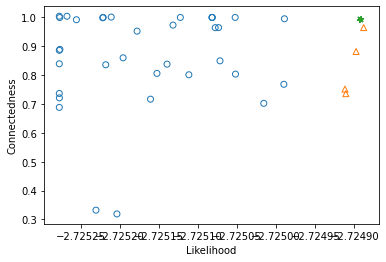

In [15]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

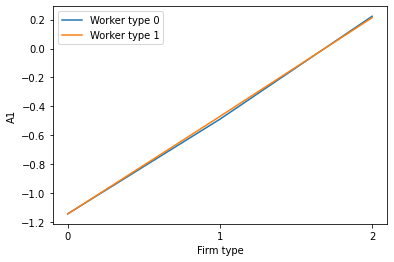

In [16]:
blm_fit.plot_A1()

In [18]:
display(blm_fit.model.A1_cat['l'])
display(blm_fit.model.A1)

array([0.03836427, 0.90382779])

array([[-1.14188226, -0.48811168,  0.22313562],
       [-1.14283887, -0.46903386,  0.21321603]])

In [19]:
display(blm_fit.model.A2_cat['l'])
display(blm_fit.model.A2)

array([0.43642748, 1.28060407])

array([[-1.52578387, -0.87756933, -0.21210006],
       [-1.53655554, -0.86300807, -0.13229126]])

In [126]:
np.expand_dims(blm_fit.model.A1_indep['l'], 1) + blm_fit.model.A1

KeyError: 'l'

In [118]:
np.expand_dims(blm_fit.model.A2_indep['l'], 1) + blm_fit.model.A2

array([[-0.21199976, -0.37135873,  0.64304726],
       [-0.56595819,  0.78867753,  0.11939135]])

In [108]:
import pandas as pd
display(sim_data.groupby('l1')['alpha1'].mean())
display(sim_data.groupby('k1')['psi1'].mean())

l1
0.0   -0.430727
1.0    0.430727
Name: alpha1, dtype: float64

k1
0.0   -0.67449
1.0    0.00000
2.0    0.67449
Name: psi1, dtype: float64

In [127]:
np.expand_dims(sim_data.groupby('l1')['alpha1'].mean().to_numpy(), 1) + np.tile(sim_data.groupby('k1')['psi1'].mean().to_numpy(), (2, 1))

array([[-1.10521705, -0.4307273 ,  0.24376245],
       [-0.24376245,  0.4307273 ,  1.10521705]])

In [128]:
blm_fit.model.A1

array([[-1.07878857, -0.34665688,  0.32289149],
       [-0.15604639,  0.49474337,  1.13039503]])

# Measuring the Model's Effectiveness

## Simulate some data

The package contains functions to simulate data. We use this here to compare model estimates to true parameter values.

## Set parameter choices

In [88]:
n_control = 2

# cat_tv_params = tw.sim_categorical_time_varying_params({'n': n_control, 'a1_mu': -2, 'a2_mu': 2, 'a1_sig': 1, 'a2_sig': 1, 's1_low': 0, 's2_low': 0, 's1_high': 0.01, 's2_high': 0.01})
cts_tnv_params = tw.sim_continuous_time_nonvarying_params({'a_mu': 0.5, 'a_sig': 0.05, 's_low': 0, 's_high': 0.01})

blm_sim_params = tw.sim_params({
    'nl': nl,
    'nk': nk,
    'firm_size': 10,
    'NNm': np.ones(shape=(nk, nk)).astype(int, copy=False),
    'NNs': np.ones(shape=nk).astype(int, copy=False),
    'mmult': 1000, 'smult': 1000,
    'a1_sig': 1, 'a2_sig': 1, 's1_low': 0, 's1_high': 0.01, 's2_low': 0, 's2_high': 0.01,
#     'categorical_time_varying_controls_dict': {'cat_tv_control': cat_tv_params},
    'continuous_time_nonvarying_controls_dict': {'cts_tnv_control': cts_tnv_params}
})
blm_params = tw.blm_params({
    'nl': nl,
    'nk': nk,
    'cons_a': ([], {}),
    'fixb': False,
    'stationary': False,
    'n_iters_movers': 100,
    'threshold_movers': 1e-7,
    'd_prior_j': 1.0001,
    'verbose': 2,
#     'categorical_time_varying_controls_dict': {'cat_tv_control': cat_tv_params},
    'continuous_time_nonvarying_controls_dict': {'cts_tnv_control': cts_tnv_params}
})

## Simulate data

In [89]:
blm_true = tw.SimBLM(blm_sim_params)
sim_data, sim_params = blm_true.simulate(return_parameters=True)
sim_data['jdata'] = bpd.BipartiteDataFrame(i=np.arange(len(sim_data['jdata'])), **sim_data['jdata'])
sim_data['sdata'] = bpd.BipartiteDataFrame(i=len(sim_data['jdata']) + np.arange(len(sim_data['sdata'])), **sim_data['sdata'])

In [90]:
print('Movers data')
display(sim_data['jdata'])
print('Stayers data')
display(sim_data['sdata'])

Movers data


,i,j1,j2,y1,y2,g1,g2,cts_tnv_control,l
0,0,31,71,0.537966,0.704519,0,0,-1.126563,0
1,1,70,45,0.396975,0.571766,0,0,-1.353463,0
2,2,56,77,0.206347,0.363751,0,0,-1.735785,0
3,3,62,68,2.342276,2.521257,0,0,2.227341,0
4,4,23,45,0.962064,1.133953,0,0,-0.318358,0
...,...,...,...,...,...,...,...,...,...
8995,8995,293,225,0.251663,-0.548974,2,2,-2.607045,1
8996,8996,212,264,2.306159,1.499688,2,2,1.160357,1
8997,8997,241,255,1.331635,0.551699,2,2,-0.612994,1
8998,8998,204,251,1.159602,0.352567,2,2,-0.924676,1


Stayers data


,i,j1,j2,y1,y2,g1,g2,cts_tnv_control,l
0,9000,94,94,0.383363,0.556029,0,0,-1.402180,0
1,9001,95,95,1.786239,1.957989,0,0,1.182543,0
2,9002,32,32,1.032509,1.192581,0,0,-0.223090,0
3,9003,18,18,1.780049,1.924227,0,0,1.140948,0
4,9004,9,9,0.671089,0.838761,0,0,-0.870589,0
...,...,...,...,...,...,...,...,...,...
2995,11995,288,288,1.200656,0.175773,2,2,-1.094325,0
2996,11996,237,237,1.767572,0.966717,2,2,0.193151,1
2997,11997,281,281,1.672428,0.633301,2,2,-0.248656,0
2998,11998,204,204,1.432799,0.638920,2,2,-0.439346,1


In [91]:
np.mean(sim_data['jdata']['y1'] - sim_params['A1'][sim_data['jdata']['l'], sim_data['jdata']['g1']] - sim_params['A_cts']['cts_tnv_control'] * sim_data['jdata']['cts_tnv_control'])

0.00014811411366371895

In [92]:
sim_params

{'A1': array([[1.14458349, 0.55939125, 1.79663824],
        [1.69223075, 2.37060911, 1.66741984]]),
 'A2': array([[ 1.3145517 ,  0.74092288,  0.76698655],
        [-0.03538265,  1.12219901,  0.86475085]]),
 'S1': array([[0.00871167, 0.00930815, 0.0083075 ],
        [0.00020538, 0.00411277, 0.00799077]]),
 'S2': array([[0.00448218, 0.00354421, 0.00695223],
        [0.00768097, 0.00749357, 0.00807546]]),
 'pk1': array([[0.89234819, 0.10765181],
        [0.36377419, 0.63622581],
        [0.59857373, 0.40142627],
        [0.94501086, 0.05498914],
        [0.64027333, 0.35972667],
        [0.49645167, 0.50354833],
        [0.76415373, 0.23584627],
        [0.86416837, 0.13583163],
        [0.24352631, 0.75647369]]),
 'pk0': array([[0.87387081, 0.12612919],
        [0.55168054, 0.44831946],
        [0.40967245, 0.59032755]]),
 'A1_cat_wi': {},
 'A2_cat_wi': {},
 'A_cat_wi': {},
 'S1_cat_wi': {},
 'S2_cat_wi': {},
 'S_cat_wi': {},
 'A1_cat': {},
 'A2_cat': {},
 'A_cat': {},
 'S1_cat': {},
 'S

## Initialize and run BLMEstimator

In [93]:
# Initialize BLM model (WRONG CODE, DELETE THIS AFTER TESTING!!!!)
blm_fit = tw.BLMModel(blm_params)
blm_fit.A1 = sim_params['A1'].copy()
blm_fit.A2 = sim_params['A2'].copy()
blm_fit.S1 = sim_params['S1'].copy()
blm_fit.S2 = sim_params['S2'].copy()
blm_fit.A1_cat = sim_params['A1_cat'].copy()
blm_fit.A2_cat = sim_params['A2_cat'].copy()
blm_fit.A_cat = sim_params['A_cat'].copy()
blm_fit.S1_cat = sim_params['S1_cat'].copy()
blm_fit.S2_cat = sim_params['S2_cat'].copy()
blm_fit.S_cat = sim_params['S_cat'].copy()
blm_fit.A1_cts = sim_params['A1_cts'].copy()
blm_fit.A2_cts = sim_params['A2_cts'].copy()
blm_fit.A_cts = sim_params['A_cts'].copy()
blm_fit.S1_cts = sim_params['S1_cts'].copy()
blm_fit.S2_cts = sim_params['S2_cts'].copy()
blm_fit.S_cts = sim_params['S_cts'].copy()
# Fit BLM estimator
blm_fit.fit_movers(jdata=sim_data['jdata'])
blm_fit.fit_stayers(sdata=sim_data['sdata'])

loop 0, liks 5.676211725455374
loop 1, liks 6.365775666208692
loop 2, liks 6.365775681677958
loop 0, liks -4913.519286273186
loop 1, liks -4913.093640394281
loop 2, liks -4913.093640394281


In [94]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=sim_data['jdata'], sdata=sim_data['sdata'], n_init=40, n_best=5, ncore=1)

  0%|                                                    | 0/40 [00:00<?, ?it/s]

Running fixm movers
loop 0, liks -2.2944138961737717
loop 1, liks -0.9165716117569787
loop 2, liks -0.7746759873793833
loop 3, liks -0.7122784793917929
loop 4, liks -0.6649054062879601
loop 5, liks -0.6313119039709865
loop 6, liks -0.613584122958128
loop 7, liks -0.6051538215155379
loop 8, liks -0.6008674688806664
loop 9, liks -0.5982827887145157
loop 10, liks -0.5963730034755776
loop 11, liks -0.5947199451067406
loop 12, liks -0.5931584721867377
loop 13, liks -0.5916232839142013
loop 14, liks -0.5900791244338583
loop 15, liks -0.5884909175842988
loop 16, liks -0.5868181503298345
loop 17, liks -0.5850248257323092
loop 18, liks -0.5830968315495444
loop 19, liks -0.5810579877880523
loop 20, liks -0.5789761275985743
loop 21, liks -0.5769530961293611
loop 22, liks -0.5750991088383769
loop 23, liks -0.5735009299358816
loop 24, liks -0.5721989310736205
loop 25, liks -0.5711841407030193
loop 26, liks -0.5704138340274412
loop 27, liks -0.5698333543337529
loop 28, liks -0.5693921452400189
loop 

  2%|█                                           | 1/40 [00:01<01:07,  1.74s/it]

loop 2, liks 3.409590975212299
loop 3, liks 3.4495890745342774
loop 4, liks 3.4233447053080632
loop 5, liks 5.3322906593303365
loop 6, liks 5.959468595397519
loop 7, liks 6.363240523382564
loop 8, liks 6.3657756817706685
loop 9, liks 6.3657756816837
Running fixm movers
loop 0, liks -2.5551352073109315
loop 1, liks -0.7438320060853132
loop 2, liks -0.5453320351467488
loop 3, liks -0.42581973492686276
loop 4, liks -0.40558929681574923
loop 5, liks -0.3919515759535462
loop 6, liks -0.3842329728782368
loop 7, liks -0.37942738209583576
loop 8, liks -0.3755970144208955
loop 9, liks -0.37202626356757246
loop 10, liks -0.3686083350528538
loop 11, liks -0.3655662821930863
loop 12, liks -0.36318827045745583
loop 13, liks -0.3615465884019755
loop 14, liks -0.36046583694241896
loop 15, liks -0.3597116139675848
loop 16, liks -0.3591148626465354
loop 17, liks -0.3585936567430445
loop 18, liks -0.3581412282780356
loop 19, liks -0.35779016330650815
loop 20, liks -0.3575587926000271
loop 21, liks -0.35

  5%|██▏                                         | 2/40 [00:03<00:56,  1.47s/it]

loop 77, liks 3.087949963968784
loop 78, liks 3.0879500661086285
loop 79, liks 3.0879501482192544
Running unconstrained movers
loop 0, liks 3.0879501482192553
loop 1, liks 3.5172177290488
loop 2, liks 3.5288117866081246
loop 3, liks 3.578791251437789
loop 4, liks 3.5825649902419716
loop 5, liks 5.696689142762557
loop 6, liks 6.340762015936299
loop 7, liks 6.365775682023395
loop 8, liks 6.365775681683887
Running fixm movers
loop 0, liks -1.7477218174042521
loop 1, liks -1.0314895683800578
loop 2, liks -0.9763642585109383
loop 3, liks -0.9276838840211029
loop 4, liks -0.8923488494818901
loop 5, liks -0.8683768124417369
loop 6, liks -0.8535145611899517
loop 7, liks -0.844614029362741
loop 8, liks -0.8392076985815486
loop 9, liks -0.8357616059677269
loop 10, liks -0.8334107686589519
loop 11, liks -0.8316832285341677
loop 12, liks -0.8303228177514235
loop 13, liks -0.8291907145803306
loop 14, liks -0.8282129267331259
loop 15, liks -0.8273519589343515
loop 16, liks -0.8265907809941848
loop 1

  8%|███▎                                        | 3/40 [00:04<00:58,  1.59s/it]

loop 90, liks 2.383797441775456
loop 91, liks 2.3838492975698955
loop 92, liks 2.383896959003865
loop 93, liks 2.383940756897724
loop 94, liks 2.383980997294091
loop 95, liks 2.3840179631071625
loop 96, liks 2.3840519156990863
loop 97, liks 2.3840830963679913
loop 98, liks 2.3841117277678334
loop 99, liks 2.3841380152418474
Running unconstrained movers
loop 0, liks 2.384162148073981
loop 1, liks 3.22160185294119
loop 2, liks 3.3960718490011295
loop 3, liks 3.60657972045494
loop 4, liks 4.108335911519263
loop 5, liks 5.827509587878622
loop 6, liks 6.305729367125621
loop 7, liks 6.365775682712662
loop 8, liks 6.3657756816844655
Running fixm movers
loop 0, liks -2.23263309922611
loop 1, liks -0.7032480413750736
loop 2, liks -0.4533618403346446
loop 3, liks -0.3733100956319476
loop 4, liks -0.3520878341643369
loop 5, liks -0.34481322836278705
loop 6, liks -0.3417224836368799
loop 7, liks -0.3403117176748149
loop 8, liks -0.339588524345625
loop 9, liks -0.3391822910579249
loop 10, liks -0.3

 10%|████▍                                       | 4/40 [00:05<00:46,  1.28s/it]

loop 30, liks 2.0098988441061243
loop 31, liks 2.0098992332780186
loop 32, liks 2.009899498662464
loop 33, liks 2.0098996796341044
loop 34, liks 2.0098998030428907
loop 35, liks 2.009899887198334
Running unconstrained movers
loop 0, liks 2.0098998871983333
loop 1, liks 2.3397290367858585
loop 2, liks 2.344138134439441
loop 3, liks 2.9368959915638024
loop 4, liks 3.4238350550711307
loop 5, liks 5.334637750326664
loop 6, liks 5.919182285516113
loop 7, liks 6.365632947375455
loop 8, liks 6.365775681691342
loop 9, liks 6.365775681683645
Running fixm movers
loop 0, liks -3.1133686614831166
loop 1, liks -1.861371042064425
loop 2, liks -1.808929720314751
loop 3, liks -1.790437401291244
loop 4, liks -1.7744718565665027
loop 5, liks -1.7039321098219378
loop 6, liks -1.585545910253009
loop 7, liks -1.5838048713896966
loop 8, liks -1.5828048673857524
loop 9, liks -1.5820540583044849
loop 10, liks -1.581463205100123
loop 11, liks -1.5809709324248513
loop 12, liks -1.5805372574105945
loop 13, liks 

 12%|█████▌                                      | 5/40 [00:06<00:38,  1.09s/it]

loop 0, liks 1.8612255201066707
loop 1, liks 2.5245293780831664
loop 2, liks 2.998770363287053
loop 3, liks 3.245718265623791
loop 4, liks 3.783540167069417
loop 5, liks 4.226399953257144
loop 6, liks 5.183033703649623
loop 7, liks 6.244271350422923
loop 8, liks 6.365775683775587
loop 9, liks 6.365775681685954
Running fixm movers
loop 0, liks -3.4213599084735598
loop 1, liks -1.7881847094517416
loop 2, liks -1.69129619299481
loop 3, liks -1.6691673362287809
loop 4, liks -1.6613753196297343
loop 5, liks -1.6571200791517078
loop 6, liks -1.6547418045355542
loop 7, liks -1.6533992028047393
loop 8, liks -1.6526197443507344
loop 9, liks -1.6521493399083609
loop 10, liks -1.6518531732737376
loop 11, liks -1.6516589929796617
loop 12, liks -1.6515270765570815
loop 13, liks -1.6514347912278573
loop 14, liks -1.651368696880774
loop 15, liks -1.6513204651009263
loop 16, liks -1.6512847249410771
loop 17, liks -1.6512578910363875
loop 18, liks -1.6512375020347676
loop 19, liks -1.6512218312877167
l

 15%|██████▌                                     | 6/40 [00:07<00:39,  1.16s/it]

loop 40, liks 2.8848784231289257
loop 41, liks 2.8899730475668948
loop 42, liks 2.890376281631989
loop 43, liks 2.89040933311723
loop 44, liks 2.8904123445043246
loop 45, liks 2.890412668074369
loop 46, liks 2.8904127099214536
Running unconstrained movers
loop 0, liks 2.8904127099214545
loop 1, liks 3.528148198168908
loop 2, liks 3.6213198306278254
loop 3, liks 4.20833058623446
loop 4, liks 5.149273539283392
loop 5, liks 6.017013502555271
loop 6, liks 6.3650848825678175
loop 7, liks 6.365775681648005
loop 8, liks 6.365775681683614
Running fixm movers
loop 0, liks -2.8352801759235238
loop 1, liks -1.2577409730802946
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 2, liks -1.1301296541434447
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 3, liks -1.0738347532276846
loop 4, liks -1.055188936226577
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 5, liks -1.0497173001683455


 18%|███████▋                                    | 7/40 [00:08<00:33,  1.03s/it]

loop 2, liks 2.344138143503509
loop 3, liks 2.936896581199374
loop 4, liks 3.4238354464181744
loop 5, liks 5.334638261651874
loop 6, liks 5.9191825208281275
loop 7, liks 6.365632949512544
loop 8, liks 6.365775681691342
loop 9, liks 6.365775681683645
Running fixm movers
loop 0, liks -4.125973308244477
loop 1, liks -1.8761458853490929
loop 2, liks -1.852733907715117
loop 3, liks -1.8404683942105984
loop 4, liks -1.8315188808585239
loop 5, liks -1.8221519947544815
loop 6, liks -1.8107271173599728
loop 7, liks -1.8010953829413885
loop 8, liks -1.7939648902408807
loop 9, liks -1.7877097791182577
loop 10, liks -1.7814563716031684
loop 11, liks -1.771734953676522
loop 12, liks -1.7626669737626515
loop 13, liks -1.758880111240895
loop 14, liks -1.7580363039227587
loop 15, liks -1.7579088816148671
loop 16, liks -1.7579049439897803
loop 17, liks -1.7579167818062111
loop 18, liks -1.7579262953421864
loop 19, liks -1.7579316589674778
loop 20, liks -1.7579340117780076
loop 21, liks -1.7579346393286

 20%|████████▊                                   | 8/40 [00:10<00:44,  1.39s/it]

loop 95, liks 1.5709379588819934
loop 96, liks 1.8831908069645749
loop 97, liks 1.5709379585931327
loop 98, liks 1.8831908069538283
loop 99, liks 1.5709379584340257
Running unconstrained movers
loop 0, liks 1.8831908069495686
loop 1, liks 2.8212388191177724
loop 2, liks 2.950525527990488
loop 3, liks 3.632217499926462
loop 4, liks 4.623149417402588
loop 5, liks 4.474627111947763
loop 6, liks 6.207498393157974
loop 7, liks 6.365775682552585
loop 8, liks 6.365775681684321
Running fixm movers
loop 0, liks -2.945929059257709
loop 1, liks -1.3570742259790691
loop 2, liks -1.205102439951899
loop 3, liks -1.1638665676442117
loop 4, liks -1.1510083733914793
loop 5, liks -1.144303328323464
loop 6, liks -1.1398674280276777
loop 7, liks -1.136602420965938
loop 8, liks -1.1341245561685147
loop 9, liks -1.1322422488261108
loop 10, liks -1.130823419892662
loop 11, liks -1.129763765016078
loop 12, liks -1.1289789544033355
loop 13, liks -1.1284017013375975
loop 14, liks -1.1279794126130034
loop 15, li

 22%|█████████▉                                  | 9/40 [00:11<00:38,  1.24s/it]

loop 8, liks 6.365775681691341
loop 9, liks 6.365775681683644
Running fixm movers
loop 0, liks -2.583956155252903
loop 1, liks -1.478996170843403
loop 2, liks -1.3635273239978876
loop 3, liks -1.3171956480160103
loop 4, liks -1.2977352933971837
loop 5, liks -1.2901250843435168
loop 6, liks -1.287556652038447
loop 7, liks -1.2862364994210382
loop 8, liks -1.2851582009043423
loop 9, liks -1.2842189304966791
loop 10, liks -1.2834830990080315
loop 11, liks -1.2829681684134657
loop 12, liks -1.2826031197225543
loop 13, liks -1.2823074513788482
loop 14, liks -1.2820402195662197
loop 15, liks -1.2817883663368779
loop 16, liks -1.28154898056532
loop 17, liks -1.2813218097208057
loop 18, liks -1.2811071229489823
loop 19, liks -1.2809051862592864
loop 20, liks -1.2807161400785998
loop 21, liks -1.2805399761191045
loop 22, liks -1.2803765422394588
loop 23, liks -1.2802255571216
loop 24, liks -1.2800866289237671
loop 25, liks -1.2799592753454974
loop 26, liks -1.2798429436699512
loop 27, liks -1.2

 25%|██████████▊                                | 10/40 [00:13<00:42,  1.41s/it]

loop 80, liks 2.637110222303255
loop 81, liks 2.63711172023647
loop 82, liks 2.6371124569179445
loop 83, liks 2.6371128426014914
loop 84, liks 2.637113064182928
loop 85, liks 2.6371132078715482
loop 86, liks 2.6371133137563056
loop 87, liks 2.6371134005959695
Running unconstrained movers
loop 0, liks 2.63711340059597
loop 1, liks 3.3824039805034385
loop 2, liks 4.293683270692127
loop 3, liks 5.492046513966523
loop 4, liks 6.365775683888462
loop 5, liks 6.365775681687207
Running fixm movers
loop 0, liks -2.2608185369241043
loop 1, liks -0.917943616152942
loop 2, liks -0.8681036097489648
loop 3, liks -0.8403582373168105
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 4, liks -0.8202050998597307
loop 5, liks -0.7670521883972653
loop 6, liks -0.6303655488683874
loop 7, liks -0.618196301193952
loop 8, liks -0.614441303571354
loop 9, liks -0.6123470558158197
loop 10, liks -0.6107518932013396
loop 11, liks -0.6094473972831231
loop 12, liks -0.60834987021

 28%|███████████▊                               | 11/40 [00:15<00:44,  1.52s/it]

loop 4, liks 3.4233447065225917
loop 5, liks 5.332290662493502
loop 6, liks 5.959468596753089
loop 7, liks 6.363240523440228
loop 8, liks 6.365775681770668
loop 9, liks 6.3657756816837
Running fixm movers
loop 0, liks -3.066862047422088
loop 1, liks -1.4057890993768771
loop 2, liks -1.3282873553997672
loop 3, liks -1.308430758567983
loop 4, liks -1.2974952172662435
loop 5, liks -1.289821615668453
loop 6, liks -1.2838716595560768
loop 7, liks -1.2789518080423297
loop 8, liks -1.2746827180960134
loop 9, liks -1.2708147930145006
loop 10, liks -1.2671552108959427
loop 11, liks -1.2635487401288248
loop 12, liks -1.259885431637778
loop 13, liks -1.2561197966565631
loop 14, liks -1.2522869771890128
loop 15, liks -1.2484996407195406
loop 16, liks -1.2449159288236056
loop 17, liks -1.2416877132355801
loop 18, liks -1.238915219308139
loop 19, liks -1.236629566101016
loop 20, liks -1.2348035827246868
loop 21, liks -1.2333759438424514
loop 22, liks -1.2322739381716121
loop 23, liks -1.231428239652

 30%|████████████▉                              | 12/40 [00:16<00:45,  1.62s/it]

loop 6, liks 6.1729168260622
loop 7, liks 6.365775682604688
loop 8, liks 6.365775681684368
Running fixm movers
loop 0, liks -3.2170922666161013
loop 1, liks -1.3471826838902017
loop 2, liks -1.248753858981627
loop 3, liks -1.1906803349190964
loop 4, liks -1.1611736468766714
loop 5, liks -1.1475840727052853
loop 6, liks -1.1411354673026757
loop 7, liks -1.137507707017396
loop 8, liks -1.1347935434419916
loop 9, liks -1.1321601533707082
loop 10, liks -1.129606296526869
loop 11, liks -1.1276679458009378
loop 12, liks -1.1265100290580674
loop 13, liks -1.1258881349835534
loop 14, liks -1.12556584696016
loop 15, liks -1.1254025211699679
loop 16, liks -1.1253219403998385
loop 17, liks -1.1252839450876662
loop 18, liks -1.1252676959049879
loop 19, liks -1.125262431092499
loop 20, liks -1.1252625715466973
loop 21, liks -1.1252652056389572
loop 22, liks -1.1252688118316205
loop 23, liks -1.1252726057941609
loop 24, liks -1.125276200242566
loop 25, liks -1.1252794232207168
loop 26, liks -1.12528

 32%|█████████████▉                             | 13/40 [00:17<00:38,  1.43s/it]

loop 37, liks 2.5627130165580505
loop 38, liks 2.785320581489349
loop 39, liks 2.8775968542514074
loop 40, liks 2.8893763798584224
loop 41, liks 2.8903288825357856
loop 42, liks 2.8904052844704373
loop 43, liks 2.890411948563673
loop 44, liks 2.890412621626502
loop 45, liks 2.8904127034388623
Running unconstrained movers
loop 0, liks 2.8904127034388623
loop 1, liks 3.5281481981687572
loop 2, liks 3.6213198306252905
loop 3, liks 4.208330586238109
loop 4, liks 5.14927353928308
loop 5, liks 6.017013502555148
loop 6, liks 6.3650848825678095
loop 7, liks 6.365775681648005
loop 8, liks 6.365775681683615
Running fixm movers
loop 0, liks -2.5675691511216145
loop 1, liks -1.1960270277863791
loop 2, liks -1.1727698466205674
loop 3, liks -1.1659747875932667
loop 4, liks -1.1628935455306517
loop 5, liks -1.1606659525130558
loop 6, liks -1.1587315847470556
loop 7, liks -1.1570216431562874
loop 8, liks -1.1555513920791887
loop 9, liks -1.1543253329302856
loop 10, liks -1.1533216701874913
loop 11, li

 35%|███████████████                            | 14/40 [00:19<00:38,  1.47s/it]

loop 48, liks 2.637115488416717
Running unconstrained movers
loop 0, liks 2.6371154884167174
loop 1, liks 3.3821823305483782
loop 2, liks 4.1381617178857075
loop 3, liks 5.138354301617428
loop 4, liks 6.365775630733063
loop 5, liks 6.36577568170202
Running fixm movers
loop 0, liks -2.757118492394585
loop 1, liks -1.6999697079501266
loop 2, liks -1.618349689757999
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 3, liks -1.576339210572102
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 4, liks -1.5489050289951487
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 5, liks -1.5285495545478918
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 6, liks -1.5125755631462157
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 7, liks -1.5010792237941135
constraints are inconsistent, no solution, passing 2 for col

 38%|████████████████▏                          | 15/40 [00:21<00:37,  1.51s/it]

loop 90, liks 1.57093795834454
loop 91, liks 1.8831908069462377
loop 92, liks 1.570937958311028
loop 93, liks 1.8831908069471053
loop 94, liks 1.570937958323565
loop 95, liks 1.8831908069459735
loop 96, liks 1.5709379583129486
loop 97, liks 1.8831908069460332
loop 98, liks 1.5709379583112433
loop 99, liks 1.8831908069461234
Running unconstrained movers
loop 0, liks 1.5709379583080663
loop 1, liks 2.7971976608889464
loop 2, liks 2.9490528393736484
loop 3, liks 3.61717456370415
loop 4, liks 4.59578354109635
loop 5, liks 4.4323919443745075
loop 6, liks 6.1729168260597
loop 7, liks 6.365775682604689
loop 8, liks 6.365775681684368
Running fixm movers
loop 0, liks -2.8770277593423197
loop 1, liks -0.875717920698998
loop 2, liks -0.508587375935657
loop 3, liks -0.4252534900222211
loop 4, liks -0.40288125759432686
loop 5, liks -0.3942621142390422
loop 6, liks -0.38828358528668766
loop 7, liks -0.38259512268474205
loop 8, liks -0.37637631538013067
loop 9, liks -0.3682376390155011
loop 10, liks 

 40%|█████████████████▏                         | 16/40 [00:22<00:33,  1.39s/it]

loop 5, liks 5.332290642970262
loop 6, liks 5.956540214536068
loop 7, liks 6.36364859706939
loop 8, liks 6.365775681766041
loop 9, liks 6.365775681683696
Running fixm movers
loop 0, liks -2.4385928827556898
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 1, liks -1.4067183481150238
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 2, liks -1.3552146684995003
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 3, liks -1.2977983844186882
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 4, liks -1.1386521270908203
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 5, liks -1.1174681412772096
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 6, liks -1.1140792361293557
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 7, liks -1.11364

constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 55, liks 0.8911176309121175
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 56, liks 0.8911376241136564
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 57, liks 0.8911543381116375
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 58, liks 0.8911683098513454
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 59, liks 0.8911799886273576
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 60, liks 0.891189750

loop 19, liks 1.6287636430593122
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 20, liks 1.6288820352430846
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 21, liks 1.629084983754305
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 22, liks 1.629435013681211
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 23, liks 1.630044640887263
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 24, liks 1.6311222401437073
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_cont

 42%|██████████████████▎                        | 17/40 [00:23<00:34,  1.49s/it]

constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 38, liks 1.7089559288718803
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 39, liks 1.7110767491445038
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 40, liks 1.716699578877043
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 41, liks 1.728597071867235
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 42, liks 1.7448787080151575
constraints are inconsistent, no solution, passing 1
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 43, liks 1.75478045103

 45%|███████████████████▎                       | 18/40 [00:25<00:37,  1.68s/it]

loop 90, liks 2.3844454828615853
loop 91, liks 2.384444228300806
loop 92, liks 2.384443078028685
loop 93, liks 2.3844420233692882
loop 94, liks 2.3844410563726752
loop 95, liks 2.3844401697476005
loop 96, liks 2.3844393568111717
loop 97, liks 2.3844386114367007
loop 98, liks 2.3844379280073214
loop 99, liks 2.384437301372651
Running unconstrained movers
loop 0, liks 2.3844367268118725
loop 1, liks 3.2218442584697953
loop 2, liks 3.3960755168412526
loop 3, liks 3.60674910607619
loop 4, liks 4.108160226497244
loop 5, liks 5.827812766520649
loop 6, liks 6.305940424625326
loop 7, liks 6.365775682708374
loop 8, liks 6.365775681684461
Running fixm movers
loop 0, liks -2.809642626626606
loop 1, liks -1.43286813765615
loop 2, liks -1.3991615185822075
loop 3, liks -1.3878610816833923
loop 4, liks -1.3809877791829535
loop 5, liks -1.3765167826187752
loop 6, liks -1.3735934664343645
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 7, liks -1.371680718056186
c

 48%|████████████████████▍                      | 19/40 [00:27<00:34,  1.62s/it]

loop 90, liks 1.8831908072602075
loop 91, liks 1.570937963786887
loop 92, liks 1.883190807207271
loop 93, liks 1.5709379622151776
loop 94, liks 1.8831908070180734
loop 95, liks 1.5709379595276391
loop 96, liks 1.8831908069971048
loop 97, liks 1.5709379590743764
loop 98, liks 1.8831908069625158
loop 99, liks 1.5709379585755678
Running unconstrained movers
loop 0, liks 1.8831908069564751
loop 1, liks 2.8212388190979394
loop 2, liks 2.950525527989496
loop 3, liks 3.6322174999240127
loop 4, liks 4.623149417400316
loop 5, liks 4.474627111945247
loop 6, liks 6.207498393155481
loop 7, liks 6.365775682552586
loop 8, liks 6.365775681684321
Running fixm movers
loop 0, liks -3.207206941609837
loop 1, liks -1.650943088156295
loop 2, liks -1.3759409221057275
loop 3, liks -1.354195940564004
loop 4, liks -1.3515743576594974
loop 5, liks -1.3502384989026144
loop 6, liks -1.3491829954888979
loop 7, liks -1.348291874506157
loop 8, liks -1.3475107806108984
loop 9, liks -1.3468090660189311
loop 10, liks -

 50%|█████████████████████▌                     | 20/40 [00:28<00:31,  1.56s/it]

loop 30, liks 2.009899097071805
loop 31, liks 2.0098994057805637
loop 32, liks 2.0098996162957583
loop 33, liks 2.0098997598509767
loop 34, liks 2.0098998577447302
Running unconstrained movers
loop 0, liks 2.0098998577447307
loop 1, liks 2.3397290367848917
loop 2, liks 2.344138133747909
loop 3, liks 2.9368959466032467
loop 4, liks 3.4238350252768015
loop 5, liks 5.334637711280968
loop 6, liks 5.919182267576849
loop 7, liks 6.365632947212603
loop 8, liks 6.365775681691342
loop 9, liks 6.365775681683645
Running fixm movers
loop 0, liks -3.4331865438208595
loop 1, liks -1.671801939619783
loop 2, liks -1.6437180146020738
loop 3, liks -1.6354083677275346
loop 4, liks -1.6314595264351242
loop 5, liks -1.629204548086508
loop 6, liks -1.6275227801341947
loop 7, liks -1.6259526005435208
loop 8, liks -1.624272745112575
loop 9, liks -1.6223588127628854
loop 10, liks -1.620147815012517
loop 11, liks -1.6176408042506576
loop 12, liks -1.6149157078370167
loop 13, liks -1.6121296783893364
loop 14, li

 52%|██████████████████████▌                    | 21/40 [00:30<00:30,  1.63s/it]

loop 4, liks 3.4233447075672045
loop 5, liks 5.332290665206863
loop 6, liks 5.959468597915925
loop 7, liks 6.3632405234896865
loop 8, liks 6.365775681770669
loop 9, liks 6.3657756816837
Running fixm movers
loop 0, liks -2.2711120269269234
loop 1, liks -1.0031114099529475
loop 2, liks -0.9280284727286934
loop 3, liks -0.8976826505596465
loop 4, liks -0.8869781930717825
loop 5, liks -0.8828220691466501
loop 6, liks -0.8807415478803445
loop 7, liks -0.879400204528165
loop 8, liks -0.8783794539207568
loop 9, liks -0.8775402518747776
loop 10, liks -0.8768332909432905
loop 11, liks -0.8762363536005773
loop 12, liks -0.875733531611074
loop 13, liks -0.875309641628789
loop 14, liks -0.8749498278967578
loop 15, liks -0.8746404110224643
loop 16, liks -0.8743696082717054
loop 17, liks -0.8741278215845395
loop 18, liks -0.873907568435294
loop 19, liks -0.8737032108369589
loop 20, liks -0.8735106112755677
loop 21, liks -0.8733267954223871
loop 22, liks -0.8731496604112119
loop 23, liks -0.872977740

 55%|███████████████████████▋                   | 22/40 [00:32<00:32,  1.78s/it]

loop 99, liks 1.5709379583802185
Running unconstrained movers
loop 0, liks 1.8831908069475265
loop 1, liks 2.821238819124009
loop 2, liks 2.950525527990787
loop 3, liks 3.6322174999270556
loop 4, liks 4.623149417402966
loop 5, liks 4.474627111947537
loop 6, liks 6.20749839315807
loop 7, liks 6.365775682552587
loop 8, liks 6.365775681684321
Running fixm movers
loop 0, liks -2.3429835708052362
loop 1, liks -1.1933064618387759
loop 2, liks -1.1164730901049336
loop 3, liks -1.107434641502023
loop 4, liks -1.1057517750171038
loop 5, liks -1.1046802890199747
loop 6, liks -1.103835711108306
loop 7, liks -1.103178743850689
loop 8, liks -1.102660694836197
loop 9, liks -1.1022421698722435
loop 10, liks -1.10189590998582
loop 11, liks -1.1016034379693538
loop 12, liks -1.1013520163991923
loop 13, liks -1.1011326368205865
loop 14, liks -1.100938765351128
loop 15, liks -1.1007655565158974
loop 16, liks -1.1006093484051704
loop 17, liks -1.1004673288704023
loop 18, liks -1.1003373084556736
loop 19, 

 57%|████████████████████████▋                  | 23/40 [00:34<00:32,  1.89s/it]

loop 92, liks 2.384443113993289
loop 93, liks 2.3844420563451942
loop 94, liks 2.384441086607371
loop 95, liks 2.3844401974692957
loop 96, liks 2.384439382228843
loop 97, liks 2.384438634742534
loop 98, liks 2.3844379493756933
loop 99, liks 2.3844373209654885
Running unconstrained movers
loop 0, liks 2.3844367447765333
loop 1, liks 3.22184427427211
loop 2, liks 3.3960755170812487
loop 3, liks 3.6067491171496697
loop 4, liks 4.108160215043637
loop 5, liks 5.827812786314569
loop 6, liks 6.305940438398928
loop 7, liks 6.365775682708375
loop 8, liks 6.365775681684461
Running fixm movers
loop 0, liks -2.3013329202674626
loop 1, liks -1.4308851503866953
loop 2, liks -1.404164028061865
loop 3, liks -1.39966110929579
loop 4, liks -1.3979747157377052
loop 5, liks -1.3970546277569211
loop 6, liks -1.3964686927827454
loop 7, liks -1.3960674445460157
loop 8, liks -1.3957788026872775
loop 9, liks -1.3955632470843822
loop 10, liks -1.395397548357061
loop 11, liks -1.3952672856038557
loop 12, liks -1

 60%|█████████████████████████▊                 | 24/40 [00:36<00:29,  1.82s/it]

loop 46, liks 3.1351378697143115
loop 47, liks 3.135137663795747
loop 48, liks 3.1351374964027277
loop 49, liks 3.1351373603273234
loop 50, liks 3.135137249710411
loop 51, liks 3.1351371597886692
Running unconstrained movers
loop 0, liks 3.135137159788669
loop 1, liks 3.396954949733333
loop 2, liks 3.4095909758354788
loop 3, liks 3.449589125685863
loop 4, liks 3.4233448128640247
loop 5, liks 5.332290939100027
loop 6, liks 5.956540341216008
loop 7, liks 6.363648602077378
loop 8, liks 6.36577568176604
loop 9, liks 6.3657756816836955
Running fixm movers
loop 0, liks -3.646307447534475
loop 1, liks -1.6645123954616745
loop 2, liks -1.622819520321651
loop 3, liks -1.6003875121553803
loop 4, liks -1.589405487516146
loop 5, liks -1.5836214494758825
loop 6, liks -1.5801572103182007
loop 7, liks -1.5778581413595687
loop 8, liks -1.576258143814657
loop 9, liks -1.575135231208139
loop 10, liks -1.5743543618651072
loop 11, liks -1.5738193762168446
loop 12, liks -1.5734583655545546
loop 13, liks -1

 62%|██████████████████████████▉                | 25/40 [00:37<00:24,  1.61s/it]

loop 6, liks 2.270408394817871
loop 7, liks 2.6828215000793834
loop 8, liks 2.682818574548153
loop 9, liks 2.6828185902575328
Running fixm movers
loop 0, liks -3.2244498593629753
loop 1, liks -0.9766863324908328
loop 2, liks -0.9602579078754643
loop 3, liks -0.9525841325847624
loop 4, liks -0.9509885895982637
loop 5, liks -0.9507519752687751
loop 6, liks -0.9508593220720998
loop 7, liks -0.9510542655172018
loop 8, liks -0.9512599303657747
loop 9, liks -0.9514498208675349
loop 10, liks -0.9516149606959128
loop 11, liks -0.9517536691392967
loop 12, liks -0.951867531674676
loop 13, liks -0.9519594968553728
loop 14, liks -0.9520329021723101
loop 15, liks -0.9520909793461138
loop 16, liks -0.9521366252830123
loop 17, liks -0.9521723208215014
loop 18, liks -0.952200128308766
loop 19, liks -0.9522217275540245
loop 20, liks -0.9522384670640293
loop 21, liks -0.9522514180106308
loop 22, liks -0.9522614246543499
loop 23, liks -0.9522691485482899
loop 24, liks -0.9522751058127409
loop 25, liks -0

 65%|███████████████████████████▉               | 26/40 [00:38<00:19,  1.36s/it]

loop 17, liks 2.8456086125240345
loop 18, liks 2.886285626069475
loop 19, liks 2.890085108394586
loop 20, liks 2.8903853150764065
loop 21, liks 2.890410130287564
loop 22, liks 2.890412426418789
loop 23, liks 2.8904126782123543
loop 24, liks 2.8904127113940996
Running unconstrained movers
loop 0, liks 2.8904127113941
loop 1, liks 3.528148198168942
loop 2, liks 3.621319830628363
loop 3, liks 4.208330586233815
loop 4, liks 5.149273539283457
loop 5, liks 6.017013502555163
loop 6, liks 6.365084882567814
loop 7, liks 6.365775681648006
loop 8, liks 6.365775681683614
Running fixm movers
loop 0, liks -2.8058065569624677
loop 1, liks -1.4775903916536473
loop 2, liks -1.4087462422965247
loop 3, liks -1.3636259004817888
loop 4, liks -1.3394947398218262
loop 5, liks -1.3266653379684064
loop 6, liks -1.3189654554089396
loop 7, liks -1.3137084581662324
loop 8, liks -1.3098017099267631
loop 9, liks -1.3067817789737044
loop 10, liks -1.3044087213200986
constraints are inconsistent, no solution, passing

 68%|█████████████████████████████              | 27/40 [00:40<00:19,  1.47s/it]

loop 5, liks 5.332290658219614
loop 6, liks 5.956540221059851
loop 7, liks 6.363648597327315
loop 8, liks 6.365775681766039
loop 9, liks 6.365775681683696
Running fixm movers
loop 0, liks -3.2487699081543533
loop 1, liks -1.6744615907865972
loop 2, liks -1.623478696707949
loop 3, liks -1.589556472670196
loop 4, liks -1.5647009562361225
loop 5, liks -1.5476975066762313
loop 6, liks -1.536299967450803
loop 7, liks -1.5282681569232872
loop 8, liks -1.5221765247920491
loop 9, liks -1.5173054089296838
loop 10, liks -1.513317142803603
loop 11, liks -1.5100273946805713
loop 12, liks -1.5073054710388085
loop 13, liks -1.5050441730037114
loop 14, liks -1.5031536083525425
loop 15, liks -1.5015599418534045
loop 16, liks -1.5002039498124644
loop 17, liks -1.499038913378161
loop 18, liks -1.4980283163555583
loop 19, liks -1.4971437180729845
loop 20, liks -1.4963629584350338
loop 21, liks -1.4956687168369494
loop 22, liks -1.4950473862460691
loop 23, liks -1.4944882060722835
loop 24, liks -1.4939825

 70%|██████████████████████████████             | 28/40 [00:42<00:19,  1.64s/it]

Running fixm movers
loop 0, liks -2.8416851655894946
loop 1, liks -1.239519955401123
loop 2, liks -1.1320407325104958
loop 3, liks -1.0706887887996965
loop 4, liks -1.0442103116006347
loop 5, liks -1.0326379577855378
loop 6, liks -1.0261992806164841
loop 7, liks -1.022024721963375
loop 8, liks -1.0191247153849379
loop 9, liks -1.017010613191615
loop 10, liks -1.0153591401287005
loop 11, liks -1.0137731801529049
loop 12, liks -1.0105628492748877
loop 13, liks -0.9953316876771191
loop 14, liks -0.9815701965796055
loop 15, liks -0.9773887369453876
loop 16, liks -0.9766871023487347
loop 17, liks -0.9764663387502317
loop 18, liks -0.9763233160927249
loop 19, liks -0.9762072020052638
loop 20, liks -0.9761051749973322
loop 21, liks -0.9760078847594711
loop 22, liks -0.9759041798304591
loop 23, liks -0.9757776183531417
loop 24, liks -0.9756011335437302
loop 25, liks -0.9753283511035766
loop 26, liks -0.9748807274958768
loop 27, liks -0.9741333650652976
loop 28, liks -0.9729150770459251
loop 29

 72%|███████████████████████████████▏           | 29/40 [00:44<00:19,  1.79s/it]

loop 7, liks 5.453273251610253
loop 8, liks 5.078040440430436
loop 9, liks 6.365774723188548
loop 10, liks 6.365775681621427
loop 11, liks 6.365775681683595
Running fixm movers
loop 0, liks -3.0966742922477204
loop 1, liks -1.6721272107321699
loop 2, liks -1.385011914264551
loop 3, liks -1.3450904758122284
loop 4, liks -1.3380054890062727
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 5, liks -1.3324570298239193
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 6, liks -1.3269009682570918
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 7, liks -1.3201138022699683
loop 8, liks -1.3070449546322298
loop 9, liks -1.259557857599719
loop 10, liks -1.008334758904318
loop 11, liks -0.8235861157126677
loop 12, liks -0.8229536481822403
loop 13, liks -0.8227170138492333
loop 14, liks -0.8225229782270065
loop 15, liks -0.8223631324325723
loop 16, liks -0.8222320376785595
loop 17, lik

 75%|████████████████████████████████▎          | 30/40 [00:45<00:16,  1.66s/it]

loop 63, liks 3.386277480476361
loop 64, liks 3.3862803626235007
loop 65, liks 3.3862817940869157
loop 66, liks 3.3862825057241928
loop 67, liks 3.3862828598328507
loop 68, liks 3.3862830361918386
loop 69, liks 3.386283124098905
Running unconstrained movers
loop 0, liks 3.386283124098905
loop 1, liks 4.469263392060236
loop 2, liks 4.49181039858857
loop 3, liks 4.650621350399377
loop 4, liks 5.216610364815818
loop 5, liks 6.075801203679469
loop 6, liks 6.365757098597442
loop 7, liks 6.365775681689843
loop 8, liks 6.365775681683643
Running fixm movers
loop 0, liks -2.380364798778112
loop 1, liks -1.1362777127063155
loop 2, liks -1.0502413650279343
loop 3, liks -0.993080237562636
loop 4, liks -0.9438007482485989
loop 5, liks -0.9343306339732206
loop 6, liks -0.9317268268456482
loop 7, liks -0.9306320098695416
loop 8, liks -0.930132498354793
loop 9, liks -0.9298827995252221
loop 10, liks -0.9297414084462764
loop 11, liks -0.9296506973690697
loop 12, liks -0.9295866392820099
loop 13, liks -

 78%|█████████████████████████████████▎         | 31/40 [00:46<00:13,  1.51s/it]

loop 4, liks 5.149273539283511
loop 5, liks 6.017013502555235
loop 6, liks 6.365084882567808
loop 7, liks 6.365775681648006
loop 8, liks 6.365775681683614
Running fixm movers
loop 0, liks -4.270163890939655
loop 1, liks -2.0874100044224884
loop 2, liks -1.9554922413980518
loop 3, liks -1.913659902716104
loop 4, liks -1.9036468532141795
loop 5, liks -1.8982607905323983
loop 6, liks -1.8958421401112386
loop 7, liks -1.8947031014367313
loop 8, liks -1.894134490469842
loop 9, liks -1.8938375535548584
loop 10, liks -1.8936720460687921
loop 11, liks -1.8935698657326208
loop 12, liks -1.8934983691419733
loop 13, liks -1.8934426765658872
loop 14, liks -1.8933962885038003
loop 15, liks -1.8933563514211071
loop 16, liks -1.8933215088133086
loop 17, liks -1.8932910011649753
loop 18, liks -1.8932643069816417
loop 19, liks -1.893241004740056
loop 20, liks -1.8932207221974564
loop 21, liks -1.8932031192800953
loop 22, liks -1.8931878832361382
loop 23, liks -1.8931747277330502
loop 24, liks -1.893163

 80%|██████████████████████████████████▍        | 32/40 [00:47<00:10,  1.30s/it]

loop 11, liks 6.365774426857115
loop 12, liks 6.365775681611949
loop 13, liks 6.365775681683588
Running fixm movers
loop 0, liks -2.531391794858427
loop 1, liks -1.1283495709069373
loop 2, liks -0.9924780885512038
loop 3, liks -0.9488222238454301
loop 4, liks -0.9246546762939484
loop 5, liks -0.9092126544392914
loop 6, liks -0.8989608613997627
loop 7, liks -0.8920495150081516
loop 8, liks -0.8873317779046546
loop 9, liks -0.8840750523193687
loop 10, liks -0.881801695122856
loop 11, liks -0.8801953437283128
loop 12, liks -0.8790452433150345
loop 13, liks -0.8782107428675675
loop 14, liks -0.8775975665309397
loop 15, liks -0.8771419331808199
loop 16, liks -0.8768001058878065
loop 17, liks -0.8765416121597789
loop 18, liks -0.8763448673942885
loop 19, liks -0.8761943380402412
loop 20, liks -0.8760786828634265
loop 21, liks -0.8759895167676642
loop 22, liks -0.8759205744099211
loop 23, liks -0.8758671339142137
loop 24, liks -0.8758256124303607
loop 25, liks -0.8757932771932505
loop 26, lik

 82%|███████████████████████████████████▍       | 33/40 [00:49<00:09,  1.29s/it]

loop 6, liks 5.919189707181816
loop 7, liks 6.365633003412109
loop 8, liks 6.365775681691341
loop 9, liks 6.365775681683644
Running fixm movers
loop 0, liks -3.1790518881067222
loop 1, liks -1.4337748206844279
loop 2, liks -1.3534457595865128
loop 3, liks -1.3074675706781789
loop 4, liks -1.2884835293876467
loop 5, liks -1.2748117639962866
loop 6, liks -1.265372483841208
loop 7, liks -1.2592679734457786
loop 8, liks -1.2554783561726803
loop 9, liks -1.2531537220359363
loop 10, liks -1.251712471500969
loop 11, liks -1.2507955401283857
loop 12, liks -1.2501917121929043
loop 13, liks -1.2497788930299345
loop 14, liks -1.2494863255956818
loop 15, liks -1.2492722785015598
loop 16, liks -1.249111432186421
loop 17, liks -1.2489878887180077
loop 18, liks -1.2488913020017978
loop 19, liks -1.2488147043715774
loop 20, liks -1.248753254880353
loop 21, liks -1.2487034958942107
loop 22, liks -1.2486628971303608
loop 23, liks -1.2486295672244234
loop 24, liks -1.248602066025415
loop 25, liks -1.2485

 85%|████████████████████████████████████▌      | 34/40 [00:50<00:07,  1.32s/it]

loop 53, liks 3.08794839236835
loop 54, liks 3.0879488026812396
loop 55, liks 3.08794913253663
loop 56, liks 3.0879493977099246
loop 57, liks 3.087949610886086
loop 58, liks 3.0879497822608326
loop 59, liks 3.0879499200307396
loop 60, liks 3.0879500307860313
loop 61, liks 3.0879501198234807
Running unconstrained movers
loop 0, liks 3.0879501198234807
loop 1, liks 3.5172177260410002
loop 2, liks 3.5288117866053126
loop 3, liks 3.578791251167144
loop 4, liks 3.582564989052204
loop 5, liks 5.696689141698676
loop 6, liks 6.340762015982747
loop 7, liks 6.365775682023395
loop 8, liks 6.3657756816838855
Running fixm movers
loop 0, liks -2.05902111957621
loop 1, liks -0.9827972799861382
loop 2, liks -0.9171286816247264
loop 3, liks -0.8699966488330829
loop 4, liks -0.8412113091084908
loop 5, liks -0.826556345348166
loop 6, liks -0.819288206667662
loop 7, liks -0.8151772158974716
loop 8, liks -0.812484534156328
loop 9, liks -0.8106804478780635
loop 10, liks -0.809517878204941
loop 11, liks -0.8

 88%|█████████████████████████████████████▋     | 35/40 [00:52<00:07,  1.59s/it]

loop 9, liks 2.6899281342451933
loop 10, liks 2.7361666621752545
loop 11, liks 2.777335240104905
loop 12, liks 2.814279723736451
loop 13, liks 2.8645242479291433
loop 14, liks 2.928050363483831
loop 15, liks 2.9593936848233544
loop 16, liks 2.985979238623393
loop 17, liks 3.050474940760128
loop 18, liks 3.1426387107238147
loop 19, liks 3.151348677272576
loop 20, liks 3.151350538299466
loop 21, liks 3.151350539259272
Running fixm movers
loop 0, liks -1.7884355168054544
loop 1, liks -0.9311648174774118
loop 2, liks -0.870016306889861
loop 3, liks -0.824965685049521
loop 4, liks -0.8003560236554984
loop 5, liks -0.7885406853897224
loop 6, liks -0.7827141807574897
loop 7, liks -0.7796341047187207
loop 8, liks -0.7778956868066828
loop 9, liks -0.7768615698100302
loop 10, liks -0.7762205267544695
loop 11, liks -0.775809013971071
loop 12, liks -0.7755355885469146
loop 13, liks -0.7753466879512952
loop 14, liks -0.7752098937772155
loop 15, liks -0.7751051143389953
loop 16, liks -0.775019652626

 90%|██████████████████████████████████████▋    | 36/40 [00:54<00:06,  1.63s/it]

loop 55, liks 3.135134562500472
loop 56, liks 3.1351349753360926
loop 57, liks 3.135135310933036
loop 58, liks 3.135135583742123
loop 59, liks 3.135135805510386
loop 60, liks 3.135135985787022
loop 61, liks 3.1351361323352642
loop 62, liks 3.1351362514656755
loop 63, liks 3.1351363483073644
Running unconstrained movers
loop 0, liks 3.135136348307364
loop 1, liks 3.396954880669335
loop 2, liks 3.4095909751812483
loop 3, liks 3.4495890719956637
loop 4, liks 3.42334469996874
loop 5, liks 5.332290645445202
loop 6, liks 5.95946858944732
loop 7, liks 6.363240523129403
loop 8, liks 6.3657756817706685
loop 9, liks 6.3657756816837
Running fixm movers
loop 0, liks -2.255913539706683
loop 1, liks -1.2377168363169275
loop 2, liks -1.0071704486481987
loop 3, liks -0.8844078477755892
loop 4, liks -0.8561356438375429
loop 5, liks -0.8491817489493944
loop 6, liks -0.847655297706046
loop 7, liks -0.8471287234332924
loop 8, liks -0.8468820319088105
loop 9, liks -0.8467634151807558
loop 10, liks -0.84670

 92%|███████████████████████████████████████▊   | 37/40 [00:54<00:03,  1.31s/it]

loop 3, liks 2.697313193438312
loop 4, liks 2.6973313098418474
loop 5, liks 2.697529434928906
loop 6, liks 2.6997313937895275
loop 7, liks 2.7185924407248385
loop 8, liks 2.780497918783429
loop 9, liks 2.863732059687941
loop 10, liks 2.941599227710783
loop 11, liks 3.0254031080556705
loop 12, liks 3.1744317886492093
loop 13, liks 3.2746561539737766
loop 14, liks 3.274661091701227
loop 15, liks 3.274661093519644
Running fixm movers
loop 0, liks -2.267236129329158
loop 1, liks -1.2635056539908123
loop 2, liks -1.194682378690844
loop 3, liks -1.1694094648750866
loop 4, liks -1.1589133173423376
loop 5, liks -1.1531449017841284
loop 6, liks -1.1492214305547124
loop 7, liks -1.146284463284723
loop 8, liks -1.144019248692781
loop 9, liks -1.1422641503373765
loop 10, liks -1.1409068300261256
loop 11, liks -1.1398573770761224
loop 12, liks -1.1390421943122828
loop 13, liks -1.1384024919909659
loop 14, liks -1.1378929092056937
loop 15, liks -1.1374795265720317
loop 16, liks -1.1371375835452808
l

 95%|████████████████████████████████████████▊  | 38/40 [00:56<00:03,  1.52s/it]

loop 3, liks 3.4495890758124843
loop 4, liks 3.4233447079946573
loop 5, liks 5.332290666321141
loop 6, liks 5.956540224525253
loop 7, liks 6.363648597464277
loop 8, liks 6.36577568176604
loop 9, liks 6.365775681683697
Running fixm movers
loop 0, liks -2.3532864546001604
loop 1, liks -0.8228644348698073
loop 2, liks -0.7092347380374519
loop 3, liks -0.6698737582348564
loop 4, liks -0.6558593123513837
loop 5, liks -0.6499206817835144
loop 6, liks -0.6464998286515254
loop 7, liks -0.6439403842354119
loop 8, liks -0.6418073838375056
loop 9, liks -0.6400038381225498
loop 10, liks -0.6385043402767052
loop 11, liks -0.6372852942890553
loop 12, liks -0.6363140871209809
loop 13, liks -0.6355529437534271
loop 14, liks -0.6349640865105554
loop 15, liks -0.6345130965817525
loop 16, liks -0.6341704394693127
loop 17, liks -0.6339117642482899
loop 18, liks -0.633717537692474
loop 19, liks -0.6335723912886784
loop 20, liks -0.6334643999492051
loop 21, liks -0.63338440358713
loop 22, liks -0.6333254183

 98%|█████████████████████████████████████████▉ | 39/40 [00:58<00:01,  1.46s/it]

loop 65, liks 3.1351360535386816
loop 66, liks 3.135136187411054
loop 67, liks 3.1351362962375084
loop 68, liks 3.1351363847023723
Running unconstrained movers
loop 0, liks 3.1351363847023728
loop 1, liks 3.3969548837669468
loop 2, liks 3.4095909752107336
loop 3, liks 3.4495890744036606
loop 4, liks 3.4233447050328922
loop 5, liks 5.33229065861617
loop 6, liks 5.956540221229461
loop 7, liks 6.363648597333981
loop 8, liks 6.36577568176604
loop 9, liks 6.365775681683696
Running fixm movers
loop 0, liks -1.903390701194459
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 1, liks -0.8409980005586074
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 2, liks -0.8075560959719877
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 3, liks -0.7856332174016862
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 4, liks -0.771168548182254
constraints are 

constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 77, liks -0.7181181275577084
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 78, liks -0.7181138721871879
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 79, liks -0.718109771220239
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 80, liks -0.718105819123333
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 81, liks -0.7181020105556405
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 82, liks -0.7180983403627208
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 83, liks -0.718094803570409
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_control'
loop 84, liks -0.718091395378885
constraints are inconsistent, no solution, passing 2 for column 'cts_tnv_con

100%|███████████████████████████████████████████| 40/40 [01:00<00:00,  1.52s/it]

loop 95, liks 1.8000702200766665
loop 96, liks 1.803088482706608
loop 97, liks 1.8057560889362412
loop 98, liks 1.808091553730721
loop 99, liks 1.8101186297880898
Running unconstrained movers
loop 0, liks 1.8118643826578797
loop 1, liks 2.35935445206913
loop 2, liks 2.5482058191762667
loop 3, liks 2.7848642932314287
loop 4, liks 3.0486134538152125
loop 5, liks 3.5463995270488877
loop 6, liks 4.717152671074608
loop 7, liks 5.544608853549902
loop 8, liks 5.240151598092357
loop 9, liks 6.365775043440016
loop 10, liks 6.365775681633492
loop 11, liks 6.365775681683603
liks_max: 6.36577568170202
Running stayers
loop 0, liks -4913.745994933026
loop 1, liks -4913.09362704567
loop 2, liks -4913.09362704567


## Finally, compare truth to estimates

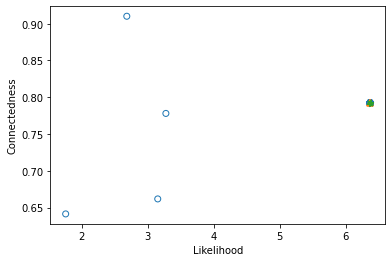

In [95]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

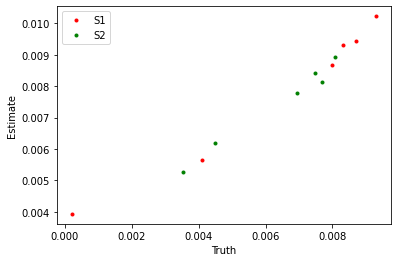

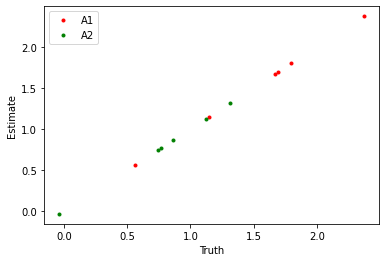

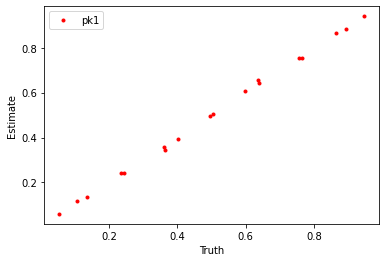

Truth: [0.54384961]
Estimate: 0.543868772928666


In [96]:
# Plot parameter truth vs. estimates
plt.plot(sim_params['S1'].flatten(), blm_fit.model.S1.flatten(), '.', label='S1', color='red')
plt.plot(sim_params['S2'].flatten(), blm_fit.model.S2.flatten(), '.', label='S2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.show()

plt.plot(sim_params['A1'].flatten(), blm_fit.model.A1.flatten(), '.', label='A1', color='red')
plt.plot(sim_params['A2'].flatten(), blm_fit.model.A2.flatten(), '.', label='A2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.show()

# plt.plot(sim_params['A1_cat']['cat_tv_control'].flatten(), blm_fit.model.A1_cat['cat_tv_control'].flatten(), '.', label='A1_cat', color='red')
# plt.plot(sim_params['A2_cat']['cat_tv_control'].flatten(), blm_fit.model.A2_cat['cat_tv_control'].flatten(), '.', label='A2_cat', color='green')
# plt.xlabel('Truth')
# plt.ylabel('Estimate')
# plt.legend()
# plt.show()

# plt.plot((sim_params['A1'].T + sim_params['A1_cat']['cat_tv_control']).T.flatten(), (blm_fit.model.A1.T + blm_fit.model.A1_cat['cat_tv_control']).T.flatten(), '.', label='A1 + A1_cat', color='red')
# plt.plot((sim_params['A2'].T + sim_params['A2_cat']['cat_tv_control']).T.flatten(), (blm_fit.model.A2.T + blm_fit.model.A2_cat['cat_tv_control']).T.flatten(), '.', label='A2 + A2_cat', color='green')
# plt.xlabel('Truth')
# plt.ylabel('Estimate')
# plt.legend()
# plt.show()

plt.plot(sim_params['pk1'].flatten(), blm_fit.model.pk1.flatten(), '.', label='pk1', color='red')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.show()

print('Truth:', sim_params['A_cts']['cts_tnv_control'])
print('Estimate:', blm_fit.model.A_cts['cts_tnv_control'])

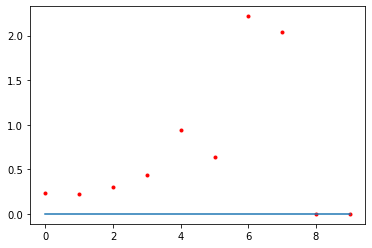

In [81]:
plt.plot(np.diff(blm_fit.model.liks1), '.', label='liks1', color='red')
plt.plot([0] * (len(blm_fit.model.liks1) - 1))

In [82]:
np.min(np.diff(blm_fit.model.liks1)) * np.max(np.diff(blm_fit.model.liks1)) > 0

False

In [83]:
blm_fit.model.liks1

array([-1.27524854, -1.04168614, -0.82131116, -0.52004901, -0.08569379,
        0.85389704,  1.49217551,  3.70865191,  5.74586379,  5.74586605,
        5.74586605])